# Extracellular Electrophysiology Data

At the Allen Institute for Brain Science we carry out in vivo extracellular electrophysiology (ecephys) experiments  in awake animals using high-density Neuropixels probes. The data from these experiments are organized into *sessions*, where each session is a distinct continuous recording period. During a session we collect:

- spike times and characteristics (such as mean waveforms) from up to 6 neuropixels probes
- local field potentials
- behavioral data, such as running speed and eye position
- visual stimuli which were presented during the session
- cell-type specific optogenetic stimuli that were applied during the session

The AllenSDK contains code for accessing across-session (project-level) metadata as well as code for accessing detailed within-session data. The standard workflow is to use project-level tools, such as `EcephysProjectCache` to identify and access sessions of interest, then delve into those sessions' data using `EcephysSession`.


Project-level
------------------
The `EcephysProjectCache` class in `allensdk.brain_observatory.ecephys.ecephys_project_cache` accesses and stores data pertaining to many sessions. You can use this class to run queries that span all collected sessions and to download data for individual sessions.
* <a href='#Obtaining-an-EcephysProjectCache'>Obtaining an `EcephysProjectCache`</a>
* <a href='#Querying-across-sessions'>Querying sessions</a>
* <a href='#Querying-across-probes'>Querying probes</a>
* <a href='#Querying-across-units'>Querying units</a>
* <a href='#Surveying-metadata'>Surveying metadata</a>


Session-level
-------------------
The `EcephysSession` class in `allensdk.brain_observatory.ecephys.ecephys_session` provides an interface to all of the data for a single session, aligned to a common clock. This notebook will show you how to use the `EcephysSession` class to extract these data.
* <a href='#Obtaining-an-EcephysSession'>Obtaining an `EcephysSession`</a>
* <a href='#Stimulus-presentations'>Stimulus information</a>
* <a href='#Spike-data'>Spike data</a>
* <a href='#Spike-histograms'>Spike histograms</a>
* <a href='#Running-speed'>Running speed</a>
* <a href='#Optogenetic-stimulation'>Optogenetic stimulation</a>
* <a href='#Local-field-potential'>Local Field Potential</a>
* <a href='#Current-source-density'>Current source density</a>
* <a href='#Waveforms'>Unitwise mean waveforms</a>
* <a href='#Suggested-excercises'>Suggested excercises</a>

Change the download timeout duration.
/Users/chenyu/opt/anaconda3/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_api/http_engine.py

Change the download timeout duration.
C:\ProgramData\Anaconda3\Lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_project_api

In [1]:
%load_ext autoreload
%autoreload 2

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:\Brain_Network\Data\Allen_Institute_Dataset/manifest.json'
elif platform=='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
else:
    print('Add new computer system settings.')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import (
    plot_mean_waveforms, 
    plot_spike_counts, 
    raster_plot)
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

import data_visualizer 

New download time: 10800


### Obtaining an `EcephysProjectCache`

In order to create an `EcephysProjectCache` object, you need to specify two things:
1. A remote source for the object to fetch data from. We will instantiate our cache using `EcephysProjectCache.from_warehouse()` to point the cache at the Allen Institute's public web API.
2. A path to a manifest json, which designates filesystem locations for downloaded data. The cache will try to read data from these locations before going to download those data from its remote source, preventing repeated downloads.

In [2]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

New download time: 10800
['brain_observatory_1.1', 'functional_connectivity']


In [4]:
session_id = 791319847  # 715093703 791319847 754829445
session = cache.get_session_data(session_id)

### Querying across sessions

Using your `EcephysProjectCache`, you can download a table listing metadata for all sessions.

In [8]:
sessions_table = cache.get_session_table()
# display(sessions_table.head())
# sessions_table.to_csv('D:\Brain_Network\Data\Allen_Institute_Dataset/session_info.csv')

units_list = cache.get_units()
df_session_units = units_list[units_list['ecephys_session_id'] == session_id]

display(df_session_units.shape)
display(df_session_units.head())


(884, 45)

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
id                                                                   
950910352           0.476196          106.785900          0.057700   
950910364           0.953652           85.808775          0.065649   
950910371           0.615593           76.898055          0.015509   
950910392           0.616317          120.519555          0.025891   
950910435           0.174735           66.974895          0.010061   

           cumulative_drift   d_prime  waveform_duration  ecephys_channel_id  \
id                                                                             
950910352            419.57  4.576155           0.151089           850264156   
950910364            231.42  5.602703           0.480737           850264158   
950910371            209.31  5.061817           0.288442           850264164   
950910392            179.71  4.219074           0.206030           850264172   
950910435             99.99  6.393051           0.206030           850264190   

           firing_rate  waveform_halfwidth  isi_violations  \
id                                                           
950910352     4.532385            0.096147        0.029797   
950910364    31.486161            0.274707        0.005998   
950910371    17.328610            0.164824        0.005242   
950910392    16.262414            0.109883        0.096884   
950910435    62.326305            0.123618        0.004243   

           isolation_distance   L_ratio  max_drift  nn_hit_rate  nn_miss_rate  \
id                                                                              
950910352           69.455405  0.002020      34.38     0.935531      0.008277   
950910364          102.847616  0.000146      23.43     0.995333      0.002786   
950910371           76.907610  0.004522      57.44     0.993333      0.007975   
950910392           65.671206  0.007306      33.65     0.944000      0.002874   
950910435          294.002222  0.000136      27.84     1.000000      0.016699   

           presence_ratio  waveform_recovery_slope  \
id                                                   
950910352            0.99                -0.153573   
950910364            0.99                -0.010004   
950910371            0.99                -0.071484   
950910392            0.99                -0.116365   
950910435            0.99                -0.045637   

           waveform_repolarization_slope  silhouette_score       snr  \
id                                                                     
950910352                       0.365539          0.080869  2.816993   
950910364                       0.147357          0.153496  2.592082   
950910371                       0.299231          0.089229  2.095077   
950910392                       0.497249          0.139601  3.024744   
950910435                       0.262594          0.146494  2.067406   

           waveform_spread  waveform_velocity_above  waveform_velocity_below  \
id                                                                             
950910352             60.0                -0.137353                 0.000000   
950910364             60.0                -0.618090                 0.343384   
950910371             70.0                 0.274707                 0.137353   
950910392             70.0                 0.000000                -0.274707   
950910435             90.0                -0.068677                -0.647523   

           ecephys_probe_id  local_index  probe_horizontal_position  \
id                                                                    
950910352         810755797            5                         11   
950910364         810755797            6                         59   
950910371         810755797            9                         11   
950910392         810755797           13                         11   
950910435         810755797           22                         59   

           pr

In [9]:
df_sub_session_units = df_session_units[['name', 'ecephys_structure_acronym']]

structure_acronyms_list = cache.get_structure_acronyms()


x = df_sub_session_units.groupby(['name', 'ecephys_structure_acronym']).size()
display(x.shape)

x = df_sub_session_units.groupby(['ecephys_structure_acronym', 'name']).size()
display(x)

x = df_sub_session_units.groupby(['ecephys_structure_acronym']).count()
display(x)


print(structure_acronyms_list )

units_statistic_table = pd.DataFrame(columns=structure_acronyms_list)
units_statistic_table.index.name = 'ecephys_session_id'
units_statistic_table.loc[session_id, x.index.values] = x['name']

display(units_statistic_table)


(25,)

ecephys_structure_acronym  name  
APN                        probeA     26
CA1                        probeA     19
                           probeC     60
                           probeD     24
                           probeE     23
                           probeF     19
CA3                        probeD     14
DG                         probeA      3
                           probeC     12
                           probeD      3
                           probeE      8
LGd                        probeD     42
                           probeE     40
LP                         probeC     91
                           probeE     48
PO                         probeC     35
                           probeE     41
PoT                        probeC      1
VISam                      probeA     30
VISl                       probeD     42
VISp                       probeC     60
VISpm                      probeB     50
VISrl                      probeE     30
                       

name
ecephys_structure_acronym      
APN                          26
CA1                         145
CA3                          14
DG                           26
LGd                          82
LP                          139
PO                           76
PoT                           1
VISam                        30
VISl                         42
VISp                         60
VISpm                        50
VISrl                        76
grey                        117

['APN', 'LP', 'MB', 'DG', 'CA1', 'VISrl', nan, 'TH', 'LGd', 'CA3', 'VIS', 'CA2', 'ProS', 'VISp', 'POL', 'VISpm', 'PPT', 'OP', 'NOT', 'HPF', 'SUB', 'VISam', 'ZI', 'LGv', 'VISal', 'VISl', 'SGN', 'SCig', 'MGm', 'MGv', 'VPM', 'grey', 'Eth', 'VPL', 'IGL', 'PP', 'PIL', 'PO', 'VISmma', 'POST', 'SCop', 'SCsg', 'SCzo', 'SCiw', 'IntG', 'MGd', 'MRN', 'LD', 'VISmmp', 'CP', 'VISli', 'PRE', 'RPF', 'LT', 'PF', 'PoT', 'VL', 'RT']


APN   LP   MB  DG  CA1 VISrl  NaN   TH LGd CA3  VIS  CA2  \
ecephys_session_id                                                            
715093703           26  139  NaN  26  145    76  NaN  NaN  82  14  NaN  NaN   

                   ProS VISp  POL VISpm  PPT   OP  NOT  HPF  SUB VISam   ZI  \
ecephys_session_id                                                            
715093703           NaN   60  NaN    50  NaN  NaN  NaN  NaN  NaN    30  NaN   

                    LGv VISal VISl  SGN SCig  MGm  MGv  VPM grey  Eth  VPL  \
ecephys_session_id                                                           
715093703           NaN   NaN   42  NaN  NaN  NaN  NaN  NaN  117  NaN  NaN   

                    IGL   PP  PIL  PO VISmma POST SCop SCsg SCzo SCiw IntG  \
ecephys_session_id                                                           
715093703           NaN  NaN  NaN  76    NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                    MGd  MRN   LD VISmmp   CP VISli  PRE  RPF   LT   PF PoT  \
ecephys_session_id                                                            
715093703           NaN  NaN  NaN    NaN  NaN   NaN  NaN  NaN  NaN  NaN   1   

                     VL   RT  
ecephys_session_id            
715093703           NaN  NaN

In [13]:
units_statistic_table = cache.get_units_area_count_table()
display(units_statistic_table)
units_statistic_table.to_csv('/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/units_count_statistic.csv')


New download time: 10800
processing  715093703
processing  719161530
processing  721123822
processing  732592105
processing  737581020
processing  739448407
processing  742951821
processing  743475441
processing  744228101
processing  746083955
processing  750332458
processing  750749662
processing  751348571
processing  754312389
processing  754829445
processing  755434585
processing  756029989
processing  757216464
processing  757970808
processing  758798717
processing  759883607
processing  760345702
processing  760693773
processing  761418226
processing  762120172
processing  762602078
processing  763673393
processing  766640955
processing  767871931
processing  768515987
processing  771160300
processing  771990200
processing  773418906
processing  774875821
processing  778240327
processing  778998620
processing  779839471
processing  781842082
processing  786091066
processing  787025148
processing  789848216
processing  791319847
processing  793224716
processing  794812542
process

APN   LP   MB   DG  CA1 VISrl  NaN   TH  LGd  CA3  VIS  \
ecephys_session_id                                                           
715093703            26  139  NaN   26  145    76  NaN  NaN   82   14  NaN   
719161530           176   28  NaN   14  108    10  NaN    9   71   14  NaN   
721123822            10   69    5   41   71    46  NaN  NaN  NaN   10   24   
732592105           NaN  NaN  NaN  NaN  NaN    64  NaN  NaN  NaN  NaN  NaN   
737581020           NaN  NaN  NaN  NaN  NaN    67  NaN  NaN  NaN  NaN  NaN   
739448407           NaN  NaN  NaN  NaN  NaN    70  NaN  NaN  NaN  NaN   97   
742951821           NaN  NaN  NaN  NaN  NaN    79  NaN  NaN  NaN  NaN  108   
743475441            34  131  NaN   12   20    68  NaN    2   42    5  NaN   
744228101            20   84  NaN   10  112    26  NaN    2    1    9  147   
746083955           NaN  NaN  NaN  NaN    7    35  NaN    2   34    5  NaN   
750332458           NaN  NaN  NaN    7   16    44  NaN  NaN    4   15  NaN   
750749662           NaN  142  NaN   26  113    41  NaN   13   82   10  NaN   
751348571            37  137    3   37   78    95  NaN  NaN   55   16  NaN   
754312389           NaN  NaN  NaN   47  135    41  NaN  NaN   27   15  NaN   
754829445            45  170  NaN   23  123    32  NaN    1   90   12  NaN   
755434585            14   27    3   15   45    49  NaN    3   44    8  NaN   
756029989            21   27    6   37  113    24  NaN   14   60   10  NaN   
757216464            47  114    3   42  112    37  NaN   18    6   13   60   
757970808           NaN   58   44   37  130    46  NaN    1   45    4  NaN   
758798717            53   39   15   40  116   NaN  NaN  NaN  NaN  NaN  NaN   
759883607            30  NaN    8   15   82   NaN  NaN    4   23    3  NaN   
760345702           NaN   17    5   27   91   NaN  NaN   10   37   30  NaN   
760693773           NaN  NaN  NaN  NaN  NaN    66  NaN  NaN  NaN  NaN  NaN   
761418226             6   44  NaN   41  145   111  NaN   16   41   11  NaN   
762120172           NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   50   
762602078            19   27    6    6  101    60  NaN  NaN  NaN    5  116   
763673393            48    3    2   30  131    44  NaN    5   77   32   51   
766640955            64  101   21   59  163    37  NaN   13   76   16  NaN   
767871931            41   83    3   32  100    33  NaN    5  NaN   19  NaN   
768515987            57   21   19   25   96    50  NaN    2   48   23  NaN   
771160300             1   43  NaN   29  269   NaN  NaN  NaN    6   42   21   
771990200            24   31  NaN   29   66    19  NaN   45   60    6  NaN   
773418906             6  NaN    1   50   72    39  NaN    2  NaN   15  NaN   
774875821            27  NaN  NaN   58  190    40  NaN  NaN  NaN  NaN  NaN   
778240327            10   51  NaN   41  240    13  NaN  NaN    2   24  NaN   
778998620            55   77    2   14  130    51  NaN  NaN  NaN   40  NaN   
779839471            28   12    3   48  133    26  NaN   10   73   22  146   
781842082            51    2    7   27  112    42  NaN   15   11   18  NaN   
786091066             9  NaN  NaN   47   86    47  NaN  NaN  NaN    3  NaN   
787025148            20   38    1   18  185    11  NaN  NaN  NaN   42    8   
789848216             2   16  NaN   37  100    24  NaN    2  NaN   25  NaN   
791319847           NaN    9  NaN   32   85    58  NaN    4    8   33  NaN   
793224716            56  101    3   27  151    39  NaN  NaN  NaN   27   23   
794812542            17   20   21   13  135    89  NaN  NaN  NaN   26  NaN   
797828357            39   67  NaN   30   49    11  NaN  NaN  NaN   29  NaN   
798911424            25   65    1   31  134    47  NaN    2  NaN   21  NaN   
799864342            11   51  NaN   20  109    29  NaN  NaN   70   16  NaN   
816200189            13   55    4   20  120   NaN  NaN  NaN  NaN    8   44   
819186360            23   78  NaN   28   65   107  NaN  NaN   34   17  NaN   
819701982             9   44    6   27  12

### Querying across probes

... or for all probes

In [7]:
probes_list = cache.get_probes()
display(probes_list)

ecephys_session_id  lfp_sampling_rate    name phase  sampling_rate  \
id                                                                              
729445648           719161530        1249.998642  probeA    3a   29999.967418   
729445650           719161530        1249.996620  probeB    3a   29999.918880   
729445652           719161530        1249.999897  probeC    3a   29999.997521   
729445654           719161530        1249.996707  probeD    3a   29999.920963   
729445656           719161530        1249.999979  probeE    3a   29999.999500   
...                       ...                ...     ...   ...            ...   
848037570           847657808        1250.009761  probeB   PXI   30000.234268   
848037572           847657808        1250.012584  probeC   PXI   30000.302018   
848037574           847657808        1250.011776  probeD   PXI   30000.282632   
848037576           847657808        1250.012826  probeE   PXI   30000.307834   
848037578           847657808        1250.011003  probeF   PXI   30000.264062   

           has_lfp_data  unit_count  channel_count  \
id                                                   
729445648          True          87            374   
729445650          True         202            368   
729445652          True         207            373   
729445654          True          93            358   
729445656          True         138            370   
...                 ...         ...            ...   
848037570          True         148            383   
848037572          True          89            383   
848037574          True         155            383   
848037576          True          89            383   
848037578          True         145            383   

                                 ecephys_structure_acronyms  
id                                                           
729445648                [APN, LP, MB, DG, CA1, VISam, nan]  
729445650      [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan]  
729445652                [APN, NOT, MB, DG, SUB, VISp, nan]  
729445654              [grey, VL, CA3, CA2, CA1, VISl, nan]  
729445656  [PO, VPM, TH, LP, LGd, CA3, DG, CA1, VISal, nan]  
...                                                     ...  
848037570              [APN, MB, NOT, DG, ProS, VISpm, nan]  
848037572                        [DG, POST, SUB, VISp, nan]  
848037574                         [DG, CA3, CA1, VISl, nan]  
848037576               [MGd, TH, DG, CA3, CA1, VISal, nan]  
848037578                [SGN, LP, TH, DG, CA1, VISrl, nan]  

[332 rows x 9 columns]

### Querying across channels

... or across channels.

In [10]:
channels_list = cache.get_channels()
display(channels_list.shape)
display(channels_list[channels_list['ecephys_session_id'] == 791319847].shape)
display(channels_list[(channels_list['ecephys_session_id'] == 791319847) & 
                      (channels_list['ecephys_probe_id'] == 805008600)].shape)

(123224, 15)

(2229, 15)

(373, 15)

### Querying across units

... as well as for sorted units.

In [11]:
units_list = cache.get_units()
display(units_list.head())

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
id                                                                   
915956282           0.611816          164.878740          0.072728   
915956340           0.439372          247.254345          0.000881   
915956345           0.500520          251.275830          0.001703   
915956349           0.424620          177.115380          0.096378   
915956356           0.512847          214.954545          0.054706   

           cumulative_drift   d_prime  waveform_duration  ecephys_channel_id  \
id                                                                             
915956282            309.71  3.910873           0.535678           850229419   
915956340            160.24  5.519024           0.563149           850229419   
915956345            129.36  3.559911           0.521943           850229419   
915956349            169.29  2.973959           0.508208           850229419   
915956356            263.01  2.936851           0.549414           850229419   

           firing_rate  waveform_halfwidth  isi_violations  \
id                                                           
915956282     6.519432            0.164824        0.104910   
915956340     9.660554            0.206030        0.006825   
915956345    12.698430            0.192295        0.044936   
915956349    16.192413            0.192295        0.120715   
915956356     2.193113            0.233501        0.430427   

           isolation_distance   L_ratio  max_drift  nn_hit_rate  nn_miss_rate  \
id                                                                              
915956282           30.546900  0.013865      27.10     0.898126      0.001599   
915956340           59.613182  0.000410       7.79     0.987654      0.000903   
915956345           47.805714  0.008281      11.56     0.930000      0.004956   
915956349           54.635515  0.010406      14.87     0.874667      0.021636   
915956356           18.136302  0.061345      18.37     0.637363      0.000673   

           presence_ratio  waveform_recovery_slope  \
id                                                   
915956282            0.99                -0.087545   
915956340            0.99                -0.104196   
915956345            0.99                -0.153127   
915956349            0.99                -0.086022   
915956356            0.99                -0.106051   

           waveform_repolarization_slope  silhouette_score       snr  \
id                                                                     
915956282                       0.480915          0.102369  1.911839   
915956340                       0.704522          0.197458  3.357908   
915956345                       0.781296          0.138827  3.362198   
915956349                       0.553393          0.136901  2.684636   
915956356                       0.632977          0.108867  2.605408   

           waveform_spread  waveform_velocity_above  waveform_velocity_below  \
id                                                                             
915956282             30.0                 0.000000                      NaN   
915956340             30.0                 0.000000                      NaN   
915956345             30.0                 0.343384                      NaN   
915956349             40.0                 0.206030                      NaN   
915956356             60.0                -0.451304                      NaN   

           ecephys_probe_id  local_index  probe_horizontal_position  \
id                                                                    
915956282         733744647            3                         27   
915956340         733744647            3                         27   
915956345         733744647            3                         27   
915956349         733744647            3                         27   
915956356         733744647            3                         27   

           pr

In [10]:
# Check probe units.
units_list = cache.get_units()
print(units_list.shape)
# probe_units = session.units[(session.units['probe_description'] == 'probeD')]
# probe_units = probe_units[[ 'ecephys_structure_acronym', 'mod_idx_dg']]
# display(np.hstack((probe_units.index.values.reshape(-1,1), probe_units.values)))

units_list

# active_units = session.select_units_by_mod_idx_dg(threshold=8)
# display(active_units)


(40010, 45)


### Surveying metadata

You can answer questions like: "what mouse genotypes were used in this dataset?" using your `EcephysProjectCache`.

In [11]:
print(f"stimulus sets: {cache.get_all_session_types()}")
print(f"genotypes: {cache.get_all_full_genotypes()}")
print(f"structures: {cache.get_structure_acronyms()}")

stimulus sets: ['brain_observatory_1.1', 'functional_connectivity']
genotypes: ['Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt', 'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt']
structures: ['APN', 'LP', 'MB', 'DG', 'CA1', 'VISrl', nan, 'TH', 'LGd', 'CA3', 'VIS', 'CA2', 'ProS', 'VISp', 'POL', 'VISpm', 'PPT', 'OP', 'NOT', 'HPF', 'SUB', 'VISam', 'ZI', 'LGv', 'VISal', 'VISl', 'SGN', 'SCig', 'MGm', 'MGv', 'VPM', 'grey', 'Eth', 'VPL', 'IGL', 'PP', 'PIL', 'PO', 'VISmma', 'POST', 'SCop', 'SCsg', 'SCzo', 'SCiw', 'IntG', 'MGd', 'MRN', 'LD', 'VISmmp', 'CP', 'VISli', 'PRE', 'RPF', 'LT', 'PF', 'PoT', 'VL', 'RT']


In order to look up a brain structure acronym, you can use our [online atlas viewer](http://atlas.brain-map.org/atlas?atlas=602630314). The AllenSDK additionally supports programmatic access to structure annotations. For more information, see the [reference space](https://allensdk.readthedocs.io/en/latest/reference_space.html) and [mouse connectivity](https://allensdk.readthedocs.io/en/latest/connectivity.html) documentation.

### Obtaining an `EcephysSession`

We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. Calling `get_session_data` on your `EcephysProjectCache` will download such a file and return an `EcephysSession` object.

`EcephysSession` objects contain methods and properties that access the data within an ecephys NWB file and cache it in memory.

In [5]:
session_id = session_id
session = cache.get_session_data(session_id)

In [ ]:
analysis_metrics1 = cache.get_unit_analysis_metrics_by_session_type(
    'brain_observatory_1.1',
    amplitude_cutoff_maximum = np.inf,
    presence_ratio_minimum = -np.inf,
    isi_violations_maximum = np.inf)
analysis_metrics2 = cache.get_unit_analysis_metrics_by_session_type(
    'functional_connectivity',
    amplitude_cutoff_maximum = np.inf,
    presence_ratio_minimum = -np.inf,
    isi_violations_maximum = np.inf)
all_metrics = pd.concat([analysis_metrics1, analysis_metrics2], sort=False)

print(str(len(all_metrics)) + ' units overall')

In [13]:
analysis_metrics1 = cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1')
analysis_metrics2 = cache.get_unit_analysis_metrics_by_session_type('functional_connectivity')
all_metrics = pd.concat([analysis_metrics1, analysis_metrics2], sort=False)

print(str(len(all_metrics)) + ' units overall')

40010 units overall


In [24]:
mod_idx_threshold = 6
selected_neurons = cache.get_units_count_by_modulation_index(mod_idx_threshold)
display(selected_neurons)

New download time: 10800


ecephys_structure_acronym  APN  CA1  CA3  DG  Eth  IGL  IntG  LD  LGd  LGv  \
ecephys_session_id                                                           
715093703                    3    3    0   0    0    0     0   0   32    0   
719161530                    4    1    0   0    0    0     0   0   15    0   
721123822                    0    0    0   0    0    0     0   0    0    0   
732592105                    0    0    0   0    0    0     0   0    0    0   
737581020                    0    0    0   0    0    0     0   0    0    0   
739448407                    0    0    0   0    0    0     0   0    0    0   
742951821                    0    0    0   0    0    0     0   0    0    0   
743475441                    3    0    0   0    0    0     0   0   21    0   
744228101                    0    0    0   0    0    2     0   0    1    0   
746083955                    0    1    0   0    0    0     0   0   21    0   
750332458                    0    0    0   0    0    2     0   0    1    0   
750749662                    0    0    0   1    0    0     0   0    8    0   
751348571                    0    0    0   0    0    0     0   0   30    0   
754312389                    0    4    0   2    0    0     0   0    6    0   
754829445                    3    3    0   0    0    0     0   0   34    0   
755434585                    0    0    0   0    0    0     0   0   14    0   
756029989                    0    1    0   0    0    0     0   0   22    0   
757216464                    0    2    0   0    1    0     0   0    5    0   
757970808                    0    2    0   1    0    0     0   0   14    0   
758798717                    1    0    0   0    0    0     0   0    0    0   
759883607                    0    1    0   0    0    0     0   0    0    0   
760345702                    0    0    0   0    0    0     0   0   16    0   
760693773                    0    0    0   0    0    0     0   0    0    0   
761418226                    0    1    0   0    0    0     0   0   22    6   
762120172                    0    0    0   0    0    0     0   0    0    0   
762602078                    0    0    0   0    0    0     0   0    0    1   
763673393                    0    1    0   1    0    0     0   0   40    0   
766640955                    2    5    0   1    0    0     0   0   12    0   
767871931                    2    1    1   0    0    0     0   0    0    0   
768515987                    2    0    2   0    0    0     0   0    7    0   
771160300                    1    2    1   0    0    0     0   0    1    0   
771990200                    1    0    0   1    0    0     0   0   12    0   
773418906                    0    2    0   0    0    0     0   0    0    0   
774875821                    1    2    0   1    0    0     0   0    0    0   
778240327                    0    1    0   0    0    0     0   0    0    0   
778998620                    0    0    0   0    0    0     0   0    0    2   
779839471                    4    2    0   1    0    0     0   0   17    0   
781842082                    1    2    1   0    0    0     0   0    1    0   
786091066                    0    2    0   1    0    0     0   0    0    0   
787025148                    1    3    1   1    0    0     0   0    0    0   
789848216                    1    1    0   1    0    0     0   3    0    0   
791319847                    0    0    0   0    0    0     0   0    0    2   
793224716                    1    3    0   0    0    0     0   0    0    0   
794812542                    0    1    0   0    0    0     0   0    0    0   
797828357                    1    0    1   0    0    4     1   0    0    0   
798911424                    1    1    0   0    0    0     0   0    0    4   
799864342                    0    1    0   1    0    0     0   0   25    0   
816200189                    0    1    0   0    0    0     0   0    0    6   
819186360                    0    2    6   0    0    0     0   0    7    0   
819701982             

This session object has some important metadata, such as the date and time at which the recording session started:

In [6]:
session.select_units_by_mod_idx_dg(7)

D:/Brain_Network/Code\allensdk\brain_observatory\ecephys\ecephys_project_api\ecephys_project_warehouse_api.py:296: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  pv_is_bool = np.issubdtype(output["p_value_rf"].values[0], bool)


snr  waveform_repolarization_slope  nn_hit_rate  \
unit_id                                                           
951771387  3.030915                       0.417778     0.998000   
951767112  4.803997                       0.308765          NaN   
951768345  0.740151                       0.081934     0.978796   
951768593  2.892584                       0.280424     0.958904   
951768735  2.040748                       0.229107     0.907692   
951769344  2.215951                       0.223477     0.978788   
951773337  1.147431                       0.097364     0.966000   
951773361  1.289944                       0.090905     0.864261   
951773407  5.236269                       1.723593     1.000000   
951773463  4.249582                       0.960931     0.961153   
951773458  2.696307                       0.681196     0.949943   
951773507  5.177223                       1.248683     0.994431   
951773496  1.155885                       0.236414     0.357357   
951773474  2.711850                       0.532378     0.757254   
951773513  2.295201                       0.341327     0.993307   
951773605  5.430170                       2.463239     0.999014   
951773565  3.865618                       1.833724     0.998667   
951773638  4.241717                       0.782328     0.973242   
951773678  2.740218                       0.534437     0.945333   
951773673  4.102550                       1.129753     0.986667   
951774176  2.026763                       0.360882     0.771930   
951763837  2.451682                       0.184346     0.922272   
951764055  2.459755                       0.139540     0.873188   
951764438  3.310545                       0.995986     0.960667   
951765944  2.873817                       0.795834     0.363184   
951764514  2.581480                       0.778403     0.951338   
951764503  2.994115                       1.020595     0.984667   
951764478  3.480201                       1.096156     0.984000   
951764608  1.468476                       0.125864     0.934000   
951764570  1.503144                       0.143975     0.978673   
951764626  3.416261                       0.811935     0.945967   
951764614  2.923728                       0.611117     0.956000   
951764648  4.272859                       1.189920     0.978706   
951764706  3.043490                       0.598525     0.946667   
951764724  2.784081                       0.478867     0.965333   
951764791  2.335969                       0.166815          NaN   
951764783  1.159781                       0.065886          NaN   
951765508  1.726895                       0.346973     0.888000   

           peak_channel_id  nn_miss_rate  waveform_amplitude  \
unit_id                                                        
951771387        850141042      0.003278          101.428470   
951767112        850137854           NaN          113.640930   
951768345        850138248      0.000347          105.622725   
951768593        850138282      0.000947          104.398320   
951768735        850138300      0.000470           69.189705   
951769344        850138314      0.000135           81.613935   
951773337        850136444      0.005946          183.096420   
951773361        850136450      0.005167          169.743405   
951773407        850136458      0.000048          555.374430   
951773463        850136466      0.000616          345.295665   
951773458        850136464      0.003056          254.717580   
951773507        850136470      0.000104          405.429375   
951773496        850136470      0.013534           91.930800   
951773474        850136468      0.019309          174.354375   
951773513        850136472      0.000246          160.136730   
951773605        850136484      0.000103          815.775480   
951773565        850136484      0.000225          604.709820   
951773638        850136490      0.000349          249.183675   
951773678        850136498      0.008667          181.2

We'll now jump in to accessing our session's data. If you ever want a complete documented list of the attributes and methods defined on `EcephysSession`, you can run `help(EcephysSession)` (or in a jupyter notebook: `EcephysSession?`).

### Sorted units

Units are putative neurons, clustered from raw voltage traces using Kilosort 2. Each unit is associated with a single *peak channel* on a single probe, though its spikes might be picked up with some attenuation on multiple nearby channels. Each unit is assigned a unique integer identifier ("unit_id") which can be used to look up its  spike times and its mean waveform.

The units for a session are recorded in an attribute called, fittingly, `units`. This is a `pandas.DataFrame` whose index is the unit id and whose columns contain summary information about the unit, its peak channel, and its associated probe.

In [9]:
session.units.head()

C:\ProgramData\Anaconda3\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_project_api\ecephys_project_warehouse_api.py:296: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  pv_is_bool = np.issubdtype(output["p_value_rf"].values[0], bool)


cumulative_drift  waveform_repolarization_slope  \
unit_id                                                      
951058482            187.92                       0.265000   
951058595            231.35                       0.450786   
951058608            200.79                       0.168063   
951058613            237.94                       0.223288   
951058664            557.95                       0.449082   

           waveform_amplitude  nn_hit_rate  amplitude_cutoff  isi_violations  \
unit_id                                                                        
951058482           64.589460     0.969333          0.005699        0.014476   
951058595          128.484525     0.981333          0.017161        0.003946   
951058608           45.285825     0.960000          0.016006        0.014151   
951058613           51.578670     0.974667          0.088164        0.063168   
951058664          113.889555     0.921333          0.072131        0.174651   

           waveform_duration  silhouette_score  firing_rate  waveform_spread  \
unit_id                                                                        
951058482           0.260972          0.144294    19.575075            120.0   
951058595           0.535678          0.173119     3.021248             30.0   
951058608           0.288442          0.074941    16.033661             70.0   
951058613           0.384590          0.087320    14.544658            100.0   
951058664           0.219765          0.090773     1.979475             20.0   

           waveform_velocity_above  waveform_velocity_below   L_ratio  \
unit_id                                                                 
951058482                -0.492183                -1.304858  0.035588   
951058595                 1.373534                -1.373534  0.023273   
951058608                 0.686767                 0.068677  0.049953   
951058613                 1.550132                -0.755444  0.005593   
951058664                 0.686767                      NaN  0.004595   

           waveform_halfwidth  isolation_distance  local_index_unit  \
unit_id                                                               
951058482            0.123618          442.391078                 8   
951058595            0.137353           72.210837                30   
951058608            0.192295           80.152292                33   
951058613            0.123618           80.712478                34   
951058664            0.096147           67.679353                46   

           max_drift  nn_miss_rate       snr  presence_ratio   d_prime  \
unit_id                                                                  
951058482      26.90      0.024229  1.948053            0.99  4.768674   
951058595      30.73      0.000947  2.399374            0.99  5.817457   
951058608      28.82      0.015102  1.208056            0.99  3.899610   
951058613      61.37      0.018168  1.471300            0.99  4.321534   
951058664      38.38      0.002624  3.193085            0.99  3.456068   

           peak_channel_id  cluster_id  waveform_recovery_slope  \
unit_id                                                           
951058482        849902136           8                -0.061722   
951058595        849902262          30                -0.039261   
951058608        849902336          33                -0.015020   
951058613        849902340          34                -0.026806   
951058664        849902390          46                -0.080051   

           waveform_PT_ratio    c50_dg  area_rf    fano_dg   fano_fl  \
unit_id                                                                
951058482           0.345894  0.723498    500.0  12.665584  2.971150   
951058595           0.287148  0.248592    400.0   4.416878  1.666667   
951058608           0.310826  1.040102   1200.0   7.794295  1.253333   
951058613           0.314381  0.051784    900.0   7.645614  1.311318   
951058664           0.2

In [79]:
display(session.structurewise_unit_counts)
display(session.probewise_unit_counts)
display(session.probe_structure_wise_unit_counts)
display(session.structure_probe_wise_unit_counts)

/Users/chenyu/Workspace/Brain_Network/Code/allensdk/brain_observatory/ecephys/ecephys_project_api/ecephys_project_warehouse_api.py:296: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  pv_is_bool = np.issubdtype(output["p_value_rf"].values[0], bool)


CA1      145
LP       139
grey     117
LGd       82
VISrl     76
PO        76
VISp      60
VISpm     50
VISl      42
VISam     30
DG        26
APN       26
CA3       14
PoT        1
Name: ecephys_structure_acronym, dtype: int64

probeC    259
probeE    190
probeB    167
probeD    125
probeA     78
probeF     65
Name: probe_description, dtype: int64

probe_description  ecephys_structure_acronym
probeA             APN                           26
                   CA1                           19
                   DG                             3
                   VISam                         30
probeB             VISpm                         50
                   grey                         117
probeC             CA1                           60
                   DG                            12
                   LP                            91
                   PO                            35
                   PoT                            1
                   VISp                          60
probeD             CA1                           24
                   CA3                           14
                   DG                             3
                   LGd                           42
                   VISl                          42
probeE             CA1                           23
                   

ecephys_structure_acronym  probe_description
APN                        probeA                26
CA1                        probeA                19
                           probeC                60
                           probeD                24
                           probeE                23
                           probeF                19
CA3                        probeD                14
DG                         probeA                 3
                           probeC                12
                           probeD                 3
                           probeE                 8
LGd                        probeD                42
                           probeE                40
LP                         probeC                91
                           probeE                48
PO                         probeC                35
                           probeE                41
PoT                        probeC                 1
VISam              

As a `pandas.DataFrame` the units table supports many straightforward filtering operations:

In [80]:
# how many units have signal to noise ratios that are greater than 4?
print(f'{session.units.shape[0]} units total')
units_with_very_high_snr = session.units[session.units['snr'] > 4]
print(f'{units_with_very_high_snr.shape[0]} units have snr > 4')

884 units total
131 units have snr > 4


... as well as some more advanced (and very useful!) operations. For more information, please see the pandas documentation. The following topics might be particularly handy:

- [selecting data](http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)
- [merging multiple dataframes](http://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)
- [grouping rows within a dataframe](http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)
- [pivot tables](http://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)

### Stimulus presentations

During the course of a session, visual stimuli are presented on a monitor to the subject. We call intervals of time where a specific stimulus is presented (and its parameters held constant!) a *stimulus presentation*.

You can find information about the stimulus presentations that were displayed during a session by accessing the `stimulus_presentations` attribute on your `EcephysSession` object. 

In [81]:
session.stimulus_presentations

color contrast frame orientation  \
stimulus_presentation_id                                    
0                         null     null  null        null   
1                         null      0.8  null          45   
2                         null      0.8  null           0   
3                         null      0.8  null          45   
4                         null      0.8  null           0   
...                        ...      ...   ...         ...   
70383                     null      0.8  null          60   
70384                     null      0.8  null          90   
70385                     null      0.8  null          60   
70386                     null      0.8  null          60   
70387                     null      0.8  null          60   

                                                   phase            pos  \
stimulus_presentation_id                                                  
0                                                   null           null   
1                         [3644.93333333, 3644.93333333]  [-40.0, 40.0]   
2                         [3644.93333333, 3644.93333333]  [-40.0, 40.0]   
3                         [3644.93333333, 3644.93333333]  [-40.0, 40.0]   
4                         [3644.93333333, 3644.93333333]  [-40.0, 40.0]   
...                                                  ...            ...   
70383                                               0.75     [0.0, 0.0]   
70384                                                0.0     [0.0, 0.0]   
70385                                                0.0     [0.0, 0.0]   
70386                                                0.5     [0.0, 0.0]   
70387                                                0.0     [0.0, 0.0]   

                                    size spatial_frequency   start_time  \
stimulus_presentation_id                                                  
0                                   null              null    13.470683   
1                           [20.0, 20.0]              0.08    73.537433   
2                           [20.0, 20.0]              0.08    73.770952   
3                           [20.0, 20.0]              0.08    74.021150   
4                           [20.0, 20.0]              0.08    74.271349   
...                                  ...               ...          ...   
70383                     [250.0, 250.0]              0.04  9133.889309   
70384                     [250.0, 250.0]              0.02  9134.139517   
70385                     [250.0, 250.0]              0.08  9134.389719   
70386                     [250.0, 250.0]              0.32  9134.639920   
70387                     [250.0, 250.0]              0.16  9134.890122   

                         stimulus_block    stimulus_name    stop_time  \
stimulus_presentation_id                                                
0                                  null      spontaneous    73.537433   
1                                     0           gabors    73.770952   
2                                     0           gabors    74.021150   
3                                     0           gabors    74.271349   
4                                     0           gabors    74.521547   
...                                 ...              ...          ...   
70383                                14  static_gratings  9134.139517   
70384                                14  static_gratings  9134.389719   
70385                                14  static_gratings  9134.639920   
70386                                14  static_gratings  9134.890122   
70387                                14  static_gratings  9135.140323   

                         temporal_frequency x_position y_position   duration  \
stimulus_presentation_id                                                       
0                                      null       null       null  60.066750   
1                                         4          0         30   0.233519   
2        

Like the units table, this is a `pandas.DataFrame`. Each row corresponds to a stimulus presentation and lists the time (on the session's master clock, in seconds) when that presentation began and ended as well as the kind of stimulus that was presented (the "stimulus_name" column) and the parameter values that were used for that presentation. Many of these parameter values don't overlap between stimulus classes, so the stimulus_presentations table uses the string `"null"` to indicate an inapplicable parameter. The index is named "stimulus_presentation_id" and many methods on `EcephysSession` use these ids.

Some of the columns bear a bit of explanation:
- stimulus_block : A block consists of multiple presentations of the same stimulus class presented with (probably) different parameter values. If during a session stimuli were presented in the following order:
    - drifting gratings
    - static gratings
    - drifting gratings
    then the blocks for that session would be [0, 1, 2]. The gray period stimulus (just a blank gray screen) never gets a block.
- duration : this is just stop_time - start_time, precalculated for convenience.

What kinds of stimuli were presented during this session? Pandas makes it easy to find out:

In [130]:
display(session.stimulus_names)  # just the unique values from the 'stimulus_name' column
trials_statistic_table = session.stimulus_presentations[['stimulus_name', 'stimulus_condition_id']]
trials_statistic_table = trials_statistic_table.groupby('stimulus_name').count()
display(trials_statistic_table)


trials_statistic_table = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'drifting_gratings']
trials_statistic_table = trials_statistic_table[['stimulus_name', 'temporal_frequency', 'orientation']]
trials_statistic_table = trials_statistic_table.groupby(['temporal_frequency', 'orientation']).count()
display(trials_statistic_table)


['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

stimulus_condition_id
stimulus_name                             
drifting_gratings                      628
flashes                                150
gabors                                3645
natural_movie_one                    18000
natural_movie_three                  36000
natural_scenes                        5950
spontaneous                             15
static_gratings                       6000

stimulus_name
temporal_frequency orientation               
1.0                0.0                     15
                   45.0                    15
                   90.0                    15
                   135.0                   14
                   180.0                   15
                   225.0                   15
                   270.0                   15
                   315.0                   15
2.0                0.0                     15
                   45.0                    15
                   90.0                    15
                   135.0                   15
                   180.0                   15
                   225.0                   15
                   270.0                   15
                   315.0                   15
4.0                0.0                     14
                   45.0                    15
                   90.0                    15
                   135.0                   15
                   180.0                   15
                   225.0                   15
                   270.0                   15
                   315.0                   15
8.0                0.0                     15
                   45.0                    15
                   90.0                    15
                   135.0                   15
                   180.0                   15
                   225.0                   15
                   270.0                   15
                   315.0                   15
15.0               0.0                     15
                   45.0                    15
                   90.0                    15
                   135.0                   15
                   180.0                   15
                   225.0                   15
                   270.0                   15
                   315.0                   15
null               null                    30

We can also obtain the `stimulus epochs` - blocks of time for which a particular kind of stimulus was presented - for this session.

In [69]:
session.get_stimulus_epochs()

start_time    stop_time    duration        stimulus_name stimulus_block
0     13.470683    73.537433   60.066750          spontaneous           null
1     73.537433   985.532551  911.995118               gabors              0
2    985.532551  1274.523973  288.991422          spontaneous           null
3   1274.523973  1573.023407  298.499434              flashes              1
4   1573.023407  1574.774823    1.751416          spontaneous           null
5   1574.774823  2174.275707  599.500885    drifting_gratings              2
6   2174.275707  2205.301633   31.025925          spontaneous           null
7   2205.301633  2805.836653  600.535020  natural_movie_three              3
8   2805.836653  2835.861733   30.025080          spontaneous           null
9   2835.861733  3136.112583  300.250850    natural_movie_one              4
10  3136.112583  3166.137683   30.025100          spontaneous           null
11  3166.137683  3765.638457  599.500775    drifting_gratings              5
12  3765.638457  4066.890123  301.251665          spontaneous           null
13  4066.890123  4667.391743  600.501620  natural_movie_three              6
14  4667.391743  4697.416823   30.025080          spontaneous           null
15  4697.416823  5380.987797  683.570975    drifting_gratings              7
16  5380.987797  5381.988653    1.000855          spontaneous           null
17  5381.988653  5862.389913  480.401260      static_gratings              8
18  5862.389913  5892.415053   30.025140          spontaneous           null
19  5892.415053  6372.832933  480.417880       natural_scenes              9
20  6372.832933  6673.083753  300.250820          spontaneous           null
21  6673.083753  7153.485033  480.401280       natural_scenes             10
22  7153.485033  7183.510123   30.025090          spontaneous           null
23  7183.510123  7663.911423  480.401300      static_gratings             11
24  7663.911423  7693.936523   30.025100          spontaneous           null
25  7693.936523  7994.187283  300.250760    natural_movie_one             12
26  7994.187283  8024.212413   30.025130          spontaneous           null
27  8024.212413  8552.153375  527.940962       natural_scenes             13
28  8552.153375  8594.688933   42.535558          spontaneous           null
29  8594.688933  9135.140323  540.451390      static_gratings             14

If you are only interested in a subset of stimuli, you can either filter using pandas or using the `get_stimulus_table` convience method:

In [70]:
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
display(stimulus_table)
display(stimulus_table[(stimulus_table['orientation']==45) & 
                       (stimulus_table['temporal_frequency']==4)].shape)
print(stimulus_table['orientation'].values[1:100])
display(stimulus_table[(stimulus_table['orientation']=='null') & 
                       (stimulus_table['temporal_frequency']=='null')].shape)

contrast orientation  \
stimulus_presentation_id                        
3798                          0.8         315   
3799                          0.8          90   
3800                          0.8         225   
3801                          0.8          90   
3802                          0.8         135   
...                           ...         ...   
49426                         0.8         135   
49427                         0.8         180   
49428                         0.8           0   
49429                         0.8         180   
49430                         0.8         270   

                                                     phase         pos  \
stimulus_presentation_id                                                 
3798                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3799                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3800                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3801                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3802                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
...                                                    ...         ...   
49426                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49427                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49428                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49429                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49430                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   

                                    size spatial_frequency   start_time  \
stimulus_presentation_id                                                  
3798                      [250.0, 250.0]              0.04  1574.774823   
3799                      [250.0, 250.0]              0.04  1577.777347   
3800                      [250.0, 250.0]              0.04  1580.779833   
3801                      [250.0, 250.0]              0.04  1583.782367   
3802                      [250.0, 250.0]              0.04  1586.784883   
...                                  ...               ...          ...   
49426                     [250.0, 250.0]              0.04  5366.976107   
49427                     [250.0, 250.0]              0.04  5369.978603   
49428                     [250.0, 250.0]              0.04  5372.981107   
49429                     [250.0, 250.0]              0.04  5375.983663   
49430                     [250.0, 250.0]              0.04  5378.986127   

                         stimulus_block      stimulus_name    stop_time  \
stimulus_presentation_id                                                  
3798                                  2  drifting_gratings  1576.776513   
3799                                  2  drifting_gratings  1579.779027   
3800                                  2  drifting_gratings  1582.781563   
3801                                  2  drifting_gratings  1585.784047   
3802                                  2  drifting_gratings  1588.786553   
...                                 ...                ...          ...   
49426                                 7  drifting_gratings  5368.977777   
49427                                 7  drifting_gratings  5371.980283   
49428                                 7  drifting_gratings  5374.982807   
49429                                 7  drifting_gratings  5377.985343   
49430                                 7  drifting_gratings  5380.987797   

                         temporal_frequency  duration  stimulus_condition_id  
stimulus_presentation_id                                                      
3798                                      4   2.00169                    246  
3799                                      8   2.00168                    247  
3800                                      2   2.00173                    248  
3801                                      2   2.00168                    249 

(15, 13)

[90.0 225.0 90.0 135.0 0.0 315.0 315.0 270.0 90.0 0.0 315.0 270.0 'null'
 'null' 315.0 315.0 315.0 180.0 'null' 45.0 315.0 90.0 270.0 135.0 90.0
 135.0 135.0 135.0 45.0 315.0 0.0 180.0 0.0 315.0 315.0 45.0 90.0 180.0
 'null' 135.0 225.0 0.0 135.0 45.0 315.0 225.0 0.0 45.0 270.0 135.0 180.0
 180.0 180.0 90.0 0.0 0.0 90.0 225.0 90.0 'null' 45.0 'null' 270.0 45.0
 180.0 225.0 225.0 45.0 90.0 315.0 270.0 270.0 270.0 0.0 45.0 270.0 270.0
 225.0 270.0 180.0 180.0 315.0 45.0 90.0 270.0 315.0 135.0 315.0 45.0
 135.0 'null' 225.0 180.0 90.0 225.0 180.0 90.0 315.0 270.0]


(30, 13)

In [106]:
stimulus_ids = session.stimulus_presentations[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings') &
    (session.stimulus_presentations['orientation'] == 45) &
    (session.stimulus_presentations['temporal_frequency'] == 4)]
display(stimulus_ids)
display(stimulus_ids.index.values)

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
display(stimulus_table.head())
display( stimulus_table[stimulus_table['orientation'].values == 45])
display( len(stimulus_table[stimulus_table['orientation'].values == 45]) )


color contrast frame orientation  \
stimulus_presentation_id                                    
3905                      null      0.8  null          45   
3916                      null      0.8  null          45   
3930                      null      0.8  null          45   
3936                      null      0.8  null          45   
31010                     null      0.8  null          45   
31049                     null      0.8  null          45   
31093                     null      0.8  null          45   
31102                     null      0.8  null          45   
31146                     null      0.8  null          45   
31163                     null      0.8  null          45   
31176                     null      0.8  null          45   
31184                     null      0.8  null          45   
49306                     null      0.8  null          45   
49344                     null      0.8  null          45   
49385                     null      0.8  null          45   

                                                     phase         pos  \
stimulus_presentation_id                                                 
3905                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3916                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3930                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3936                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31010                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31049                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31093                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31102                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31146                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31163                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31176                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
31184                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49306                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49344                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49385                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   

                                    size spatial_frequency   start_time  \
stimulus_presentation_id                                                  
3905                      [250.0, 250.0]              0.04  1896.043237   
3916                      [250.0, 250.0]              0.04  1929.070833   
3930                      [250.0, 250.0]              0.04  1971.105953   
3936                      [250.0, 250.0]              0.04  1989.120963   
31010                     [250.0, 250.0]              0.04  3193.160227   
31049                     [250.0, 250.0]              0.04  3310.258073   
31093                     [250.0, 250.0]              0.04  3442.368423   
31102                     [250.0, 250.0]              0.04  3469.390977   
31146                     [250.0, 250.0]              0.04  3601.501347   
31163                     [250.0, 250.0]              0.04  3652.543943   
31176                     [250.0, 250.0]              0.04  3691.576577   
31184                     [250.0, 250.0]              0.04  3715.596657   
49306                     [250.0, 250.0]              0.04  5006.675137   
49344                     [250.0, 250.0]              0.04  5120.770447   
49385                     [250.0, 250.0]              0.04  5243.873283   

                         stimulus_block      stimulus_name    stop_time  \
stimulus_presentation_id                                                  
3905                                  2  drifting_gratings  1898.044917   
3916                                  2  drifting_gratings  1931.072523   
3930                                  2  drifting_gratings  1973.107623   
3936                                  2  drifting_gratings  1991.122693   
31

array([ 3905,  3916,  3930,  3936, 31010, 31049, 31093, 31102, 31146,
       31163, 31176, 31184, 49306, 49344, 49385])

contrast orientation  \
stimulus_presentation_id                        
3798                          0.8         315   
3799                          0.8          90   
3800                          0.8         225   
3801                          0.8          90   
3802                          0.8         135   

                                                     phase         pos  \
stimulus_presentation_id                                                 
3798                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3799                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3800                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3801                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3802                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   

                                    size spatial_frequency   start_time  \
stimulus_presentation_id                                                  
3798                      [250.0, 250.0]              0.04  1574.774823   
3799                      [250.0, 250.0]              0.04  1577.777347   
3800                      [250.0, 250.0]              0.04  1580.779833   
3801                      [250.0, 250.0]              0.04  1583.782367   
3802                      [250.0, 250.0]              0.04  1586.784883   

                         stimulus_block      stimulus_name    stop_time  \
stimulus_presentation_id                                                  
3798                                  2  drifting_gratings  1576.776513   
3799                                  2  drifting_gratings  1579.779027   
3800                                  2  drifting_gratings  1582.781563   
3801                                  2  drifting_gratings  1585.784047   
3802                                  2  drifting_gratings  1588.786553   

                         temporal_frequency  duration  stimulus_condition_id  
stimulus_presentation_id                                                      
3798                                      4   2.00169                    246  
3799                                      8   2.00168                    247  
3800                                      2   2.00173                    248  
3801                                      2   2.00168                    249  
3802                                      8   2.00167                    250

contrast orientation  \
stimulus_presentation_id                        
3818                          0.8          45   
3827                          0.8          45   
3834                          0.8          45   
3842                          0.8          45   
3846                          0.8          45   
...                           ...         ...   
49364                         0.8          45   
49382                         0.8          45   
49385                         0.8          45   
49416                         0.8          45   
49424                         0.8          45   

                                                     phase         pos  \
stimulus_presentation_id                                                 
3818                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3827                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3834                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3842                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
3846                      [21211.93333333, 21211.93333333]  [0.0, 0.0]   
...                                                    ...         ...   
49364                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49382                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49385                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49416                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   
49424                     [21211.93333333, 21211.93333333]  [0.0, 0.0]   

                                    size spatial_frequency   start_time  \
stimulus_presentation_id                                                  
3818                      [250.0, 250.0]              0.04  1634.824993   
3827                      [250.0, 250.0]              0.04  1661.847597   
3834                      [250.0, 250.0]              0.04  1682.865123   
3842                      [250.0, 250.0]              0.04  1706.885213   
3846                      [250.0, 250.0]              0.04  1718.895253   
...                                  ...               ...          ...   
49364                     [250.0, 250.0]              0.04  5180.820607   
49382                     [250.0, 250.0]              0.04  5234.865757   
49385                     [250.0, 250.0]              0.04  5243.873283   
49416                     [250.0, 250.0]              0.04  5336.951027   
49424                     [250.0, 250.0]              0.04  5360.971097   

                         stimulus_block      stimulus_name    stop_time  \
stimulus_presentation_id                                                  
3818                                  2  drifting_gratings  1636.826683   
3827                                  2  drifting_gratings  1663.849267   
3834                                  2  drifting_gratings  1684.866833   
3842                                  2  drifting_gratings  1708.886883   
3846                                  2  drifting_gratings  1720.896963   
...                                 ...                ...          ...   
49364                                 7  drifting_gratings  5182.822277   
49382                                 7  drifting_gratings  5236.867417   
49385                                 7  drifting_gratings  5245.874953   
49416                                 7  drifting_gratings  5338.952697   
49424                                 7  drifting_gratings  5362.972757   

                         temporal_frequency  duration  stimulus_condition_id  
stimulus_presentation_id                                                      
3818                                      1   2.00169                    261  
3827                                      1   2.00167                    261  
3834                                      2   2.00171                    269  
3842                                     15   2.00167                    275 

75

We might also want to know what the total set of available parameters is. The `get_stimulus_parameter_values` method provides a dictionary mapping stimulus parameters to the set of values that were applied to those parameters:

In [6]:
session.get_stimulus_parameter_values()

{'color': array([-1.0, 1.0], dtype=object),
 'contrast': array([0.01, 0.02, 0.04, 0.08, 0.13, 0.2, 0.35, 0.6, 0.8, 1.0],
       dtype=object),
 'frame': array([-1.0, 0.0, 1.0, ..., 3597.0, 3598.0, 3599.0], dtype=object),
 'orientation': array([0.0, 30.0, 45.0, 60.0, 90.0, 120.0, 135.0, 150.0, 180.0, 225.0,
        270.0, 315.0], dtype=object),
 'phase': array(['0.0', '0.25', '0.5', '0.75', '[0.0, 0.0]',
        '[19258.96666667, 19258.96666667]',
        '[3644.93333333, 3644.93333333]', '[5308.98333333, 5308.98333333]'],
       dtype=object),
 'pos': array(['[-10.0, 20.0]', '[0.0, 0.0]'], dtype=object),
 'size': array(['[1920.0, 1080.0]', '[20.0, 20.0]', '[250.0, 250.0]',
        '[300.0, 300.0]'], dtype=object),
 'spatial_frequency': array(['0.02', '0.04', '0.08', '0.16', '0.32', '[0.0, 0.0]'], dtype=object),
 'temporal_frequency': array([1.0, 2.0, 4.0, 8.0, 15.0], dtype=object),
 'x_position': array([-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0],
       dtype=object),
 'y

In [17]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

color: [-1.0 1.0]
contrast: [0.8 1.0]
frame: [-1.0 0.0 1.0 ... 3597.0 3598.0 3599.0]
orientation: [0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]
phase: ['0.0' '0.25' '0.5' '0.75' '[0.0, 0.0]' '[3644.93333333, 3644.93333333]'
 '[42471.86666667, 42471.86666667]']
pos: ['[-40.0, -20.0]' '[0.0, 0.0]']
size: ['[1920.0, 1080.0]' '[20.0, 20.0]' '[250.0, 250.0]' '[300.0, 300.0]']
spatial_frequency: ['0.02' '0.04' '0.08' '0.16' '0.32' '[0.0, 0.0]']
temporal_frequency: [1.0 2.0 4.0 8.0 15.0]
x_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]
y_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]


Each distinct state of the monitor is called a "stimulus condition". Each presentation in the stimulus presentations table exemplifies such a condition. This is encoded in its stimulus_condition_id field.

To get the full list of conditions presented in a session, use the stimulus_conditions attribute:

In [18]:
session.stimulus_conditions.head()

color colorSpace contrast depth flipHoriz flipVert  \
stimulus_condition_id                                                      
0                      null       null     null  null      null     null   
1                      null        rgb      0.8     0      null     null   
2                      null        rgb      0.8     0      null     null   
3                      null        rgb      0.8     0      null     null   
4                      null        rgb      0.8     0      null     null   

                      frame interpolate    mask opacity orientation  \
stimulus_condition_id                                                 
0                      null        null    null    null        null   
1                      null           0  circle       1          45   
2                      null           0  circle       1          45   
3                      null           0  circle       1          90   
4                      null           0  circle       1          90   

                                                phase             pos  \
stimulus_condition_id                                                   
0                                                null            null   
1                      [3644.93333333, 3644.93333333]  [-40.0, -20.0]   
2                      [3644.93333333, 3644.93333333]  [-40.0, -20.0]   
3                      [3644.93333333, 3644.93333333]  [-40.0, -20.0]   
4                      [3644.93333333, 3644.93333333]  [-40.0, -20.0]   

                           rgbPedestal          size spatial_frequency  \
stimulus_condition_id                                                    
0                                 null          null              null   
1                      [0.0, 0.0, 0.0]  [20.0, 20.0]              0.08   
2                      [0.0, 0.0, 0.0]  [20.0, 20.0]              0.08   
3                      [0.0, 0.0, 0.0]  [20.0, 20.0]              0.08   
4                      [0.0, 0.0, 0.0]  [20.0, 20.0]              0.08   

                      stimulus_name temporal_frequency   tex texRes units  \
stimulus_condition_id                                                       
0                       spontaneous               null  null   null  null   
1                            gabors                  4   sin    256   deg   
2                            gabors                  4   sin    256   deg   
3                            gabors                  4   sin    256   deg   
4                            gabors                  4   sin    256   deg   

                      x_position y_position    color_triplet  
stimulus_condition_id                                         
0                           null       null             null  
1                             40         30  [1.0, 1.0, 1.0]  
2                            -30         10  [1.0, 1.0, 1.0]  
3                             10        -10  [1.0, 1.0, 1.0]  
4                             30         40  [1.0, 1.0, 1.0]

### Spike data

The `EcephysSession` object holds spike times (in seconds on the session master clock) for each unit. These are stored in a dictionary, which maps unit ids (the index values of the units table) to arrays of spike times.

In [22]:
units_with_very_high_snr = session.units[session.units['snr'] > 4]
# grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
high_snr_unit_ids = units_with_very_high_snr.index.values
unit_id = high_snr_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]
display(high_snr_unit_ids)

37471 spikes were detected for unit 951058793 at times:


array([951058793, 951058895, 951059065, 951059460, 951059530, 951060149,
       951060157, 951060215, 951060338, 951061042, 951061637, 951061655,
       951061702, 951061695, 951061754, 951061801, 951061957, 951061938,
       951062059, 951062052, 951062118, 951062096, 951062502, 951063300,
       951063312, 951063388, 951065560, 951065978, 951069985, 951066200,
       951066443, 951068662, 951068746, 951069127, 951070769, 951071281,
       951071440, 951071547, 951071757, 951071871, 951073305, 951073398,
       951073507, 951073709, 951073702, 951073734, 951073728], dtype=int64)

You can also obtain spikes tagged with the stimulus presentation during which they occurred:

In [23]:
# get spike times from the first block of drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

times.head()

stimulus_presentation_id    unit_id  \
spike_time                                         
1590.470424                      3798  951061801   
1590.472368                      3798  951071440   
1590.476068                      3798  951073709   
1590.477624                      3798  951062052   
1590.478568                      3798  951071871   

             time_since_stimulus_presentation_onset  
spike_time                                           
1590.470424                                0.001251  
1590.472368                                0.003196  
1590.476068                                0.006896  
1590.477624                                0.008451  
1590.478568                                0.009396

In [42]:
high_snr_unit_ids

array([951058793, 951058895, 951059065, 951059460, 951059530, 951060149,
       951060157, 951060215, 951060338, 951061042, 951061637, 951061655,
       951061702, 951061695, 951061754, 951061801, 951061957, 951061938,
       951062059, 951062052, 951062118, 951062096, 951062502, 951063300,
       951063312, 951063388, 951065560, 951065978, 951069985, 951066200,
       951066443, 951068662, 951068746, 951069127, 951070769, 951071281,
       951071440, 951071547, 951071757, 951071871, 951073305, 951073398,
       951073507, 951073709, 951073702, 951073734, 951073728], dtype=int64)

In [43]:
spikes_table = session.presentationwise_spike_times(
    stimulus_presentation_ids=[3798, 3927],
    unit_ids=[951058793, 951058895]
)

display(spikes_table)
display(spikes_table.shape)

stimulus_presentation_id    unit_id  \
spike_time                                         
1590.514393                      3798  951058793   
1590.544727                      3798  951058895   
1590.610360                      3798  951058895   
1590.674660                      3798  951058895   
1590.727860                      3798  951058793   
1590.736660                      3798  951058895   
1590.792894                      3798  951058895   
1590.813627                      3798  951058895   
1590.860394                      3798  951058895   
1590.895161                      3798  951058895   
1591.133494                      3798  951058793   
1591.225028                      3798  951058895   
1591.518095                      3798  951058793   
1591.593728                      3798  951058895   
1591.675295                      3798  951058793   
1591.714328                      3798  951058895   
1591.733262                      3798  951058793   
1591.863928                      3798  951058793   
1591.969762                      3798  951058793   
1592.076595                      3798  951058793   
1592.215262                      3798  951058793   
1592.219796                      3798  951058793   
1592.226396                      3798  951058793   
1592.236429                      3798  951058793   
1592.249862                      3798  951058793   
1592.402229                      3798  951058793   
1977.796981                      3927  951058793   
1977.841114                      3927  951058793   
1978.076815                      3927  951058895   
1978.128148                      3927  951058793   
1978.258748                      3927  951058793   
1978.272448                      3927  951058895   
1978.329415                      3927  951058793   
1978.427482                      3927  951058895   
1978.467848                      3927  951058895   
1978.712582                      3927  951058793   
1978.842882                      3927  951058895   
1978.880682                      3927  951058793   
1978.954816                      3927  951058895   
1979.284616                      3927  951058793   
1979.371350                      3927  951058895   
1979.617983                      3927  951058793   
1979.667850                      3927  951058895   

             time_since_stimulus_presentation_onset  
spike_time                                           
1590.514393                                0.045221  
1590.544727                                0.075554  
1590.610360                                0.141188  
1590.674660                                0.205488  
1590.727860                                0.258688  
1590.736660                                0.267488  
1590.792894                                0.323721  
1590.813627                                0.344455  
1590.860394                                0.391222  
1590.895161                                0.425988  
1591.133494                                0.664322  
1591.225028                                0.755855  
1591.518095                                1.048922  
1591.593728                                1.124556  
1591.675295                                1.206123  
1591.714328                                1.245156  
1591.733262                                1.264089  
1591.863928                                1.394756  
1591.969762                                1.500590  
1592.076595                                1.607423  
1592.215262                                1.746090  
1592.219796                                1.750623  
1592.226396                                1.757223  
1592.236429                                1.767257  
1592.249862                                1.780690  
1592.402229                                1.933057  
1977.796981                                0.004124  
1977.841114                                0.048257  
1978.076815                                0.283957 

(43, 3)

In [33]:
spikes_table = session.trialwise_spike_times(
    stimulus_presentation_ids=[3798, 3927],
    unit_ids=[951058793, 951058895],
    trial_time_window=[-0.0, 2.0]
)

# display(spikes_table)
display(spikes_table.shape)

(43, 3)

In [4]:
session_units = session.units
# display(session_units)

# display(session.units[
#     (session.units['ecephys_structure_acronym'] == 'VISp')])

# display(session.units[
#     (session.units['ecephys_structure_acronym'] == 'TH') &
#     (session.units['probe_description'] == 'probeC')])

# display(session.units[
#     (session.units['ecephys_structure_acronym'] == 'TH') &
#     (session.units['probe_description'] == 'probeC')])

# Check probe units.
# probe_units = session.units[(session.units['probe_description'] == 'probeD')]
# probe_units = probe_units[[ 'ecephys_structure_acronym', 'mod_idx_dg']]
# display(np.hstack((probe_units.index.values.reshape(-1,1), probe_units.values)))

active_units = session.select_units_by_mod_idx_dg(threshold=8)
display(active_units)

cumulative_drift  waveform_repolarization_slope  \
unit_id                                                      
951061906            186.17                       0.325825   
951061938             69.27                       0.892531   
951062019            169.40                       0.608093   
951062105            123.23                       0.534415   
951062301            235.95                       0.549964   
951062307            279.61                       0.158571   
951062451            171.79                       0.721861   
951062469            178.60                       0.705751   
951062495            108.01                       0.729515   
951064231            379.07                       0.195722   
951065830            194.29                       0.743623   

           waveform_amplitude  nn_hit_rate  amplitude_cutoff  isi_violations  \
unit_id                                                                        
951061906          110.866860     0.832642          0.000270        0.024429   
951061938          266.190600     0.993711          0.000014        0.000000   
951062019          204.835605     0.994278          0.000306        0.000000   
951062105          185.624595     0.937500          0.000078        0.009846   
951062301          129.201735     0.681159          0.011298        0.049408   
951062307           91.923000     0.930470          0.013947        0.238689   
951062451          230.738625     0.883721          0.003183        0.056666   
951062469          232.768770     0.965517          0.001232        0.056103   
951062495          266.587035     0.974576          0.001266        0.058580   
951064231           55.526640     0.770667          0.092801        0.007674   
951065830          173.628780     0.942667          0.043064        0.014374   

           waveform_duration  silhouette_score  firing_rate  waveform_spread  \
unit_id                                                                        
951061906           0.604355          0.146810     2.974250             80.0   
951061938           0.590620          0.258154     1.718955             60.0   
951062019           0.494472          0.234040     5.350210            100.0   
951062105           0.590620          0.095839     8.764865            110.0   
951062301           0.192295          0.015576     6.446082             80.0   
951062307           0.618090          0.063071     3.623567             60.0   
951062451           0.576884          0.126760     1.127488             80.0   
951062469           0.576884          0.212625     0.801244             70.0   
951062495           0.590620          0.014726     1.753453             60.0   
951064231           0.398325          0.072657    20.552110             80.0   
951065830           0.219765          0.065785    24.420458             30.0   

           waveform_velocity_above  waveform_velocity_below       L_ratio  \
unit_id                                                                     
951061906                 0.480737                -0.412060  8.110701e-03   
951061938                 0.824121                 0.343384  5.022846e-07   
951062019                 0.686767                 0.549414  5.116600e-05   
951062105                 1.192806                 0.274707  1.115611e-02   
951062301                -0.068677                 0.206030  1.521547e-02   
951062307                 0.686767                 0.000000  7.226606e-03   
951062451                 0.618090                 0.068677  4.111203e-04   
951062469                 0.686767                 0.000000  1.486420e-04   
951062495                 1.098827                 0.343384  5.412652e-04   
951064231                -1.079206                 1.373534  3.845737e-02   
951065830                -0.686767                 1.373534  9.320279e-03   

           waveform_halfwidth  isolation_distance  local_index_unit  \
unit_id                                          

VISp951061537
VISp951061574
VISp951061568
VISp951061556
VISp951061549
VISp951061607
VISp951061643
VISp951061649
VISp951061637
VISp951061655
VISp951061702
VISp951061695
VISp951061772
VISp951061727
VISp951061715
VISp951061777
VISp951061754
VISp951061747
VISp951061801
VISp951061788
VISp951061847
VISp951061833
VISp951061894
VISp951061888
VISp951061931
VISp951061918
VISp951061912
VISp951061906
VISp951061876
VISp951061957
VISp951061944
VISp951061938
VISp951061993
VISp951062808
VISp951062023
VISp951062019
VISp951062059
VISp951062052
VISp951062013
VISp951062088
VISp951062079
VISp951062075
VISp951062124
VISp951062118
VISp951062112
VISp951062108
VISp951062105
VISp951062100
VISp951062096
VISp951062092
VISp951062175
VISp951062162
VISp951062156
VISp951062136
VISp951062143
VISp951062212
VISp951062203
VISp951062898
VISp951062199
VISp951062186
VISp951062285
VISp951062242
VISp951062236
VISp951062230
VISp951062223
VISp951062301
VISp951062291
VISp951062307
VISp951062272
VISp951062344
VISp951062330
VISp95

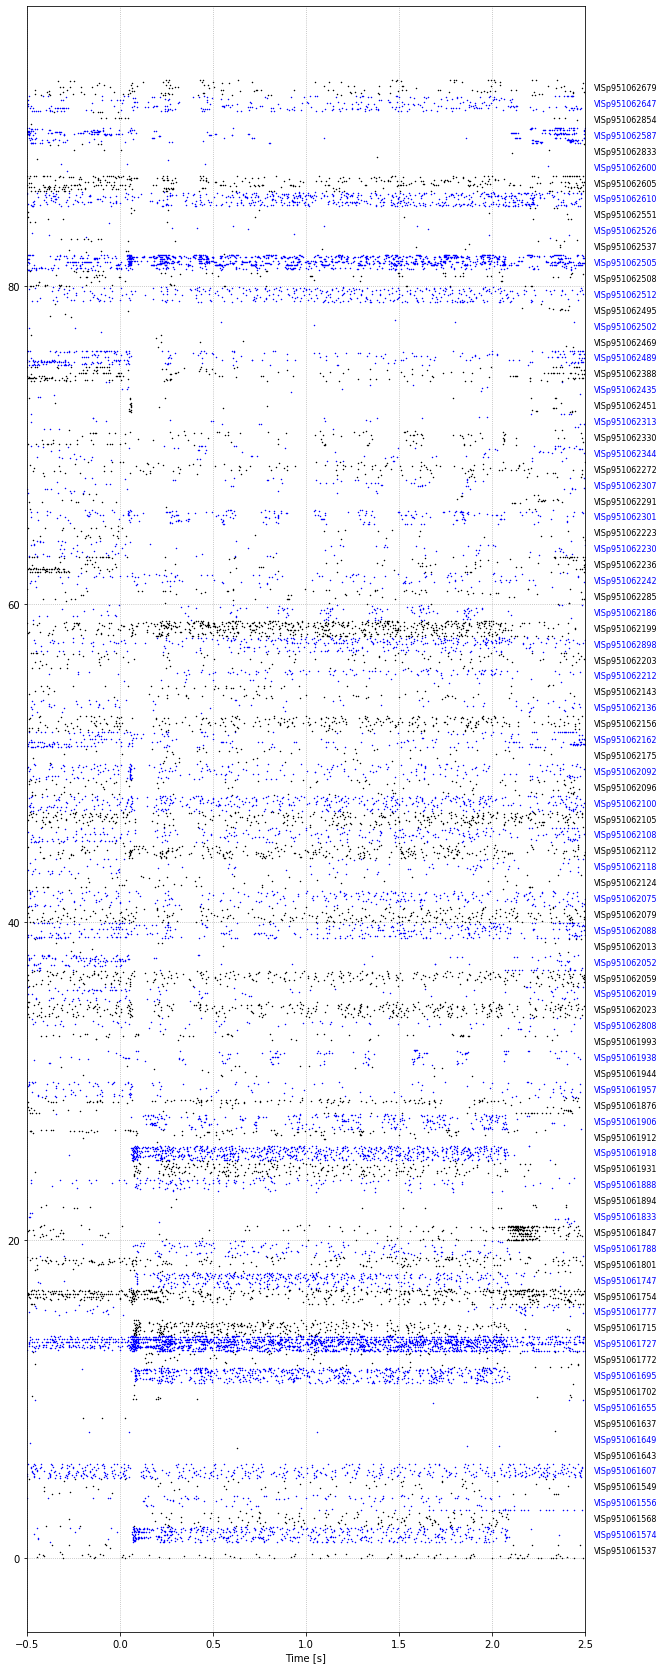

In [57]:
# trials_indices = [3798, 3927],
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_indices = stimulus_table[
    (stimulus_table['orientation']==45) & 
    (stimulus_table['temporal_frequency']==4)].index.values

# units_indices = [951058793, 951058895]
units_indices = session.units[
    (session.units['ecephys_structure_acronym'] == 'VISp') &
    (session.units['probe_description'] == 'probeC')].index.values

visualizer = data_visualizer.AllenInstituteDataVisualizer(session)
visualizer.plot_spikes_per_unit(
    stimulus_presentation_ids=trials_indices,
    unit_ids=units_indices,
    trial_time_window=[-0.5, 2.5])



In [72]:
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_indices = stimulus_table[
    (stimulus_table['orientation']==45) & 
    (stimulus_table['temporal_frequency']==4)].index.values

visualizer = data_visualizer.AllenInstituteDataVisualizer(session)
visualizer.plot_all_spikes_per_unit_per_probe(
    stimulus_presentation_ids=trials_indices,
    trial_time_window=[-0.5, 2.5])


New download time: 10800


NameError: name 'data_visualizer' is not defined

We can make raster plots of these data:

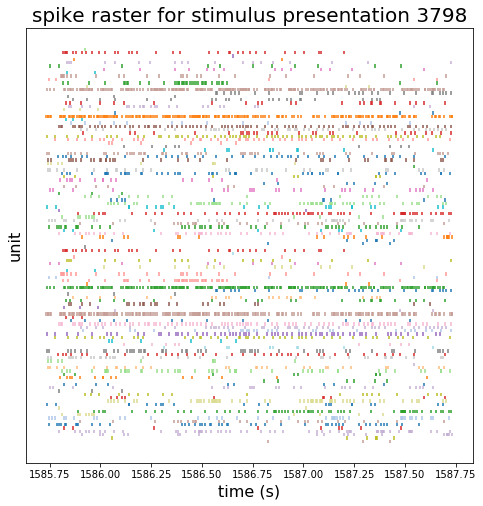

color                                                null
contrast                                              0.8
frame                                                null
orientation                                           180
phase                    [42471.86666667, 42471.86666667]
pos                                            [0.0, 0.0]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                        1585.73
stimulus_block                                          2
stimulus_name                           drifting_gratings
stop_time                                         1587.74
temporal_frequency                                      2
x_position                                           null
y_position                                           null
duration                                          2.00168
stimulus_condition_id                                 246
Name: 3798, dt

In [21]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

We can access summary spike statistics for stimulus conditions and unit

In [22]:
stats = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

# display the parameters associated with each condition
stats = pd.merge(stats, session.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)

stats.head()

spike_count  stimulus_presentation_count  \
unit_id   stimulus_condition_id                                             
951799336 246                             13                           15   
951800977 246                             26                           15   
951801127 246                            103                           15   
951801187 246                              4                           15   
951801462 246                             83                           15   

                                 spike_mean  spike_std  spike_sem color  \
unit_id   stimulus_condition_id                                           
951799336 246                      0.866667   1.995232   0.515167  null   
951800977 246                      1.733333   2.737743   0.706882  null   
951801127 246                      6.866667   7.414914   1.914523  null   
951801187 246                      0.266667   0.593617   0.153271  null   
951801462 246                      5.533333   2.587516   0.668094  null   

                                colorSpace contrast depth flipHoriz flipVert  \
unit_id   stimulus_condition_id                                                
951799336 246                          rgb      0.8     0      null     null   
951800977 246                          rgb      0.8     0      null     null   
951801127 246                          rgb      0.8     0      null     null   
951801187 246                          rgb      0.8     0      null     null   
951801462 246                          rgb      0.8     0      null     null   

                                frame interpolate  mask opacity orientation  \
unit_id   stimulus_condition_id                                               
951799336 246                    null           0  None       1         180   
951800977 246                    null           0  None       1         180   
951801127 246                    null           0  None       1         180   
951801187 246                    null           0  None       1         180   
951801462 246                    null           0  None       1         180   

                                                            phase         pos  \
unit_id   stimulus_condition_id                                                 
951799336 246                    [42471.86666667, 42471.86666667]  [0.0, 0.0]   
951800977 246                    [42471.86666667, 42471.86666667]  [0.0, 0.0]   
951801127 246                    [42471.86666667, 42471.86666667]  [0.0, 0.0]   
951801187 246                    [42471.86666667, 42471.86666667]  [0.0, 0.0]   
951801462 246                    [42471.86666667, 42471.86666667]  [0.0, 0.0]   

                                     rgbPedestal            size  \
unit_id   stimulus_condition_id                                    
951799336 246                    [0.0, 0.0, 0.0]  [250.0, 250.0]   
951800977 246                    [0.0, 0.0, 0.0]  [250.0, 250.0]   
951801127 246                    [0.0, 0.0, 0.0]  [250.0, 250.0]   
951801187 246                    [0.0, 0.0, 0.0]  [250.0, 250.0]   
951801462 246                    [0.0, 0.0, 0.0]  [250.0, 250.0]   

                                spatial_frequency      stimulus_name  \
unit_id   stimulus_condition_id                                        
951799336 246                                0.04  drifting_gratings   
951800977 246                                0.04  drifting_gratings   
951801127 246                                0.04  drifting_gratings   
951801187 246                                0.04  drifting_gratings   
951801462 246                                0.04  drifting_gratings   

                                temporal_frequency  tex texRes units  \
unit_id   stimulus_condition_id                                        
951799336 246                                    2  sin    256   deg   
951800977 246                                    2  sin    256   deg   
951801127 246 

Using these data, we can ask for each unit: which stimulus condition evoked the most activity on average?

In [23]:
with_repeats = stats[stats["stimulus_presentation_count"] >= 5]

highest_mean_rate = lambda df: df.loc[df['spike_mean'].idxmax()]
max_rate_conditions = with_repeats.groupby('unit_id').apply(highest_mean_rate)
max_rate_conditions.head()

spike_count  stimulus_presentation_count  spike_mean  spike_std  \
unit_id                                                                      
951799336           81                           15    5.400000   9.287472   
951800977           41                           15    2.733333   2.840188   
951801127          209                           15   13.933333   9.728211   
951801187           53                           15    3.533333   5.902380   
951801462          136                           15    9.066667   5.161211   

           spike_sem color colorSpace contrast  depth flipHoriz flipVert  \
unit_id                                                                    
951799336   2.398015  null        rgb      0.8    0.0      null     null   
951800977   0.733333  null        rgb      0.8    0.0      null     null   
951801127   2.511813  null        rgb      0.8    0.0      null     null   
951801187   1.523988  null        rgb      0.8    0.0      null     null   
951801462   1.332619  null        rgb      0.8    0.0      null     null   

          frame  interpolate  mask  opacity orientation  \
unit_id                                                   
951799336  null          0.0  None      1.0           0   
951800977  null          0.0  None      1.0          45   
951801127  null          0.0  None      1.0          90   
951801187  null          0.0  None      1.0         270   
951801462  null          0.0  None      1.0          45   

                                      phase         pos      rgbPedestal  \
unit_id                                                                    
951799336  [42471.86666667, 42471.86666667]  [0.0, 0.0]  [0.0, 0.0, 0.0]   
951800977  [42471.86666667, 42471.86666667]  [0.0, 0.0]  [0.0, 0.0, 0.0]   
951801127  [42471.86666667, 42471.86666667]  [0.0, 0.0]  [0.0, 0.0, 0.0]   
951801187  [42471.86666667, 42471.86666667]  [0.0, 0.0]  [0.0, 0.0, 0.0]   
951801462  [42471.86666667, 42471.86666667]  [0.0, 0.0]  [0.0, 0.0, 0.0]   

                     size spatial_frequency      stimulus_name  \
unit_id                                                          
951799336  [250.0, 250.0]              0.04  drifting_gratings   
951800977  [250.0, 250.0]              0.04  drifting_gratings   
951801127  [250.0, 250.0]              0.04  drifting_gratings   
951801187  [250.0, 250.0]              0.04  drifting_gratings   
951801462  [250.0, 250.0]              0.04  drifting_gratings   

          temporal_frequency  tex  texRes units x_position y_position  \
unit_id                                                                 
951799336                  4  sin   256.0   deg       null       null   
951800977                  1  sin   256.0   deg       null       null   
951801127                  1  sin   256.0   deg       null       null   
951801187                  4  sin   256.0   deg       null       null   
951801462                  2  sin   256.0   deg       null       null   

             color_triplet  
unit_id                     
951799336  [1.0, 1.0, 1.0]  
951800977  [1.0, 1.0, 1.0]  
951801127  [1.0, 1.0, 1.0]  
951801187  [1.0, 1.0, 1.0]  
951801462  [1.0, 1.0, 1.0]

### Spike histograms

It is commonly useful to compare spike data from across units and stimulus presentations, all relative to the onset of a stimulus presentation. We can do this using the `presentationwise_spike_counts` method. 

In [58]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 200)

# look at responses to the flash stimulus
flash_250_ms_stimulus_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'flashes'
].index.values

# and get a set of units with only decent snr
decent_snr_unit_ids = session.units[
    session.units['snr'] >= 1.5
].index.values

spike_counts_da = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=decent_snr_unit_ids
)
spike_counts_da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 199, unit_id: 510)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951058482 ... 951073920

In [65]:
# print(np.linspace(-0.01, 0.4, 201))
print(time_bin_edges.shape)
print(spike_counts_da.shape)
print(spike_counts_da.stimulus_presentation_id)


(200,)
(150, 199, 510)
<xarray.DataArray 'stimulus_presentation_id' (stimulus_presentation_id: 150)>
array([3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658,
       3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670,
       3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682,
       3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694,
       3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706,
       3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718,
       3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730,
       3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742,
       3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754,
       3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766,
       3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778,
       3779, 3780, 3781, 3782,

[autoreload of allensdk.brain_observatory.ecephys.ecephys_session failed: Traceback (most recent call last):
  File "/Users/chenyu/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/chenyu/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/chenyu/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/chenyu/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/Users/chenyu/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/Users/chenyu/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload

In [12]:
time_bin_edges = np.linspace(-0.5, 2.5, 3/0.005 + 1)

# trials_indices = [3798, 3927],
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_indices = stimulus_table[
    (stimulus_table['orientation']==45) & 
    (stimulus_table['temporal_frequency']==4)].index.values

# units_indices = [951058793, 951058895]
units_indices = session.units[
    (session.units['ecephys_structure_acronym'] == 'TH') &
    (session.units['probe_description'] == 'probeC')].index.values

print(trials_indices)
print(units_indices)

spike_histogram = session.unitwise_spike_histogram(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=trials_indices,
    unit_ids=units_indices,
    smooth_sigma=0.8
)


[ 3879  3927  3929  3960  3964 31054 31096 31128 31171 49233 49245 49262
 49347 49394 49420]
[951062741 951060223 951060215]


In [7]:
print(spike_histogram.shape)
print(spike_histogram)


(600, 3)
<xarray.DataArray 'unitwise_histogram' (time_relative_to_stimulus_onset: 600, unit_id: 3)>
array([[0.        , 0.        , 0.        ],
       [0.        , 0.06666667, 0.        ],
       [0.        , 0.06666667, 0.        ],
       ...,
       [0.        , 0.        , 0.13333333],
       [0.        , 0.06666667, 0.2       ],
       [0.06666667, 0.        , 0.        ]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.5 ... 2.495
  * unit_id                          (unit_id) int64 951062741 ... 951060215


This has returned a new (to this notebook) data structure, the `xarray.DataArray`. You can think of this as similar to a 3+D `pandas.DataFrame`, or as a `numpy.ndarray` with labeled axes and indices. See the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more information. In the mean time, the salient features are:

- Dimensions : Each axis on each data variable is associated with a named dimension. This lets us see unambiguously what the axes of our array mean.
- Coordinates : Arrays of labels for each sample on each dimension.

xarray is nice because it forces code to be explicit about dimensions and coordinates, improving readability and avoiding bugs. However, you can always convert to numpy or pandas data structures as follows:
- to pandas: `spike_counts_ds.to_dataframe()` produces a multiindexed dataframe
- to numpy: `spike_counts_ds.values` gives you access to the underlying numpy array

We can now plot spike counts for a particular presentation:

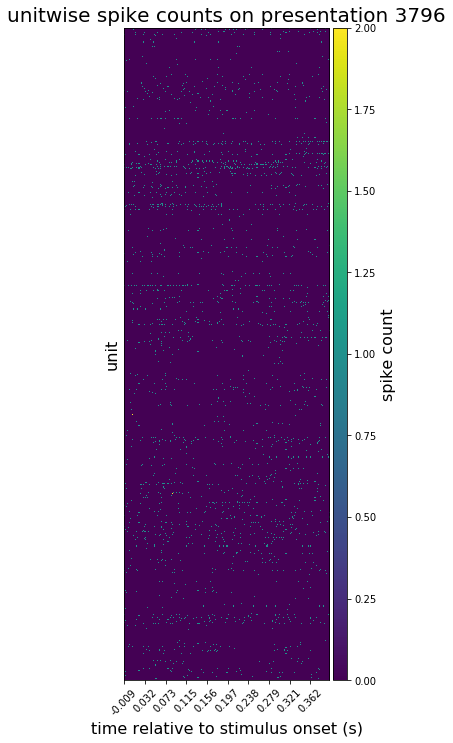

In [25]:
presentation_id = 3796 # chosen arbitrarily
plot_spike_counts(
    spike_counts_da.loc[{'stimulus_presentation_id': presentation_id}], 
    spike_counts_da['time_relative_to_stimulus_onset'],
    'spike count', 
    f'unitwise spike counts on presentation {presentation_id}'
)
plt.show()

We can also average across all presentations, adding a new data array to the dataset. Notice that this one no longer has a stimulus_presentation_id dimension, as we have collapsed it by averaging.

In [26]:
mean_spike_counts = spike_counts_da.mean(dim='stimulus_presentation_id')
mean_spike_counts

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 199, unit_id: 631)>
array([[0.026667, 0.1     , 0.08    , ..., 0.006667, 0.      , 0.006667],
       [0.026667, 0.066667, 0.046667, ..., 0.02    , 0.      , 0.      ],
       [0.02    , 0.113333, 0.033333, ..., 0.033333, 0.      , 0.      ],
       ...,
       [0.026667, 0.093333, 0.053333, ..., 0.006667, 0.      , 0.      ],
       [0.026667, 0.066667, 0.026667, ..., 0.006667, 0.02    , 0.      ],
       [0.026667, 0.12    , 0.02    , ..., 0.      , 0.      , 0.      ]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951814884 ... 951814312

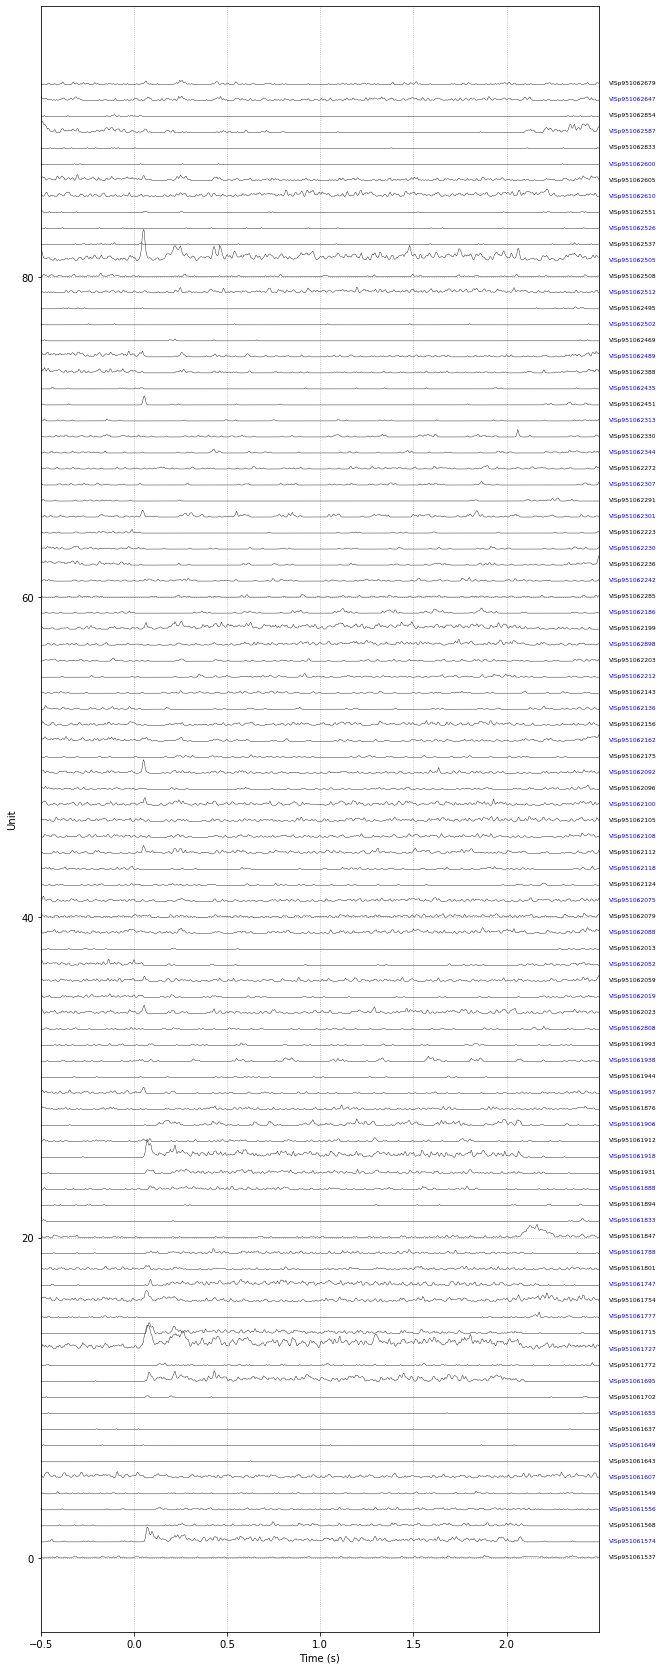

In [20]:
visualizer = data_visualizer.AllenInstituteDataVisualizer(session)
time_bin_edges = np.linspace(-0.5, 2.5, 3/0.005 + 1)

# trials_indices = [3798, 3927],
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_indices = stimulus_table[
    (stimulus_table['orientation']==45) & 
    (stimulus_table['temporal_frequency']==4)].index.values

# units_indices = [951058793, 951058895]
units_indices = session.units[
    (session.units['ecephys_structure_acronym'] == 'VISp') &
    (session.units['probe_description'] == 'probeC')].index.values

visualizer.plot_psth_per_unit(
    time_bin_edges=time_bin_edges,
    stimulus_presentation_ids=trials_indices,
    unit_ids=units_indices,
    smooth_sigma=0.8)

In [42]:
session.units.head()
display(session.units['probe_description'])
print('probeA' in session.units['probe_description'].values)
display(session.units[session.units['probe_description'] == 'probeC'])
display(session.units['ecephys_structure_acronym'].unique())

display(session.units['ecephys_structure_acronym'].unique())

probe_units = session.units[session.units['probe_description'] == 'probeC']
print(probe_units['probe_horizontal_position'].values)
print(probe_units['probe_vertical_position'].values)


unit_id
951058482    probeA
951058595    probeA
951058608    probeA
951058613    probeA
951058664    probeA
              ...  
951073889    probeF
951073905    probeF
951073896    probeF
951073933    probeF
951073920    probeF
Name: probe_description, Length: 555, dtype: object

True


cumulative_drift  waveform_repolarization_slope  \
unit_id                                                      
951060149            125.81                       1.031190   
951060126            223.09                       0.554547   
951060091            130.94                       0.645536   
951060134            183.96                       0.420755   
951060162            164.70                       0.256403   
...                     ...                            ...   
951062833            123.93                       0.413809   
951062587            132.09                       0.289734   
951062854            108.24                       0.494903   
951062647            139.74                       0.379594   
951062679            247.85                       0.017524   

           waveform_amplitude  nn_hit_rate  amplitude_cutoff  isi_violations  \
unit_id                                                                        
951060149          198.336255     0.994634          0.000089        0.010486   
951060126          117.815100     0.956667          0.041888        0.212926   
951060091          114.401235     0.920667          0.014288        0.099818   
951060134          141.226215     0.940000          0.048503        0.487827   
951060162           81.062865     0.964667          0.083581        0.118709   
...                       ...          ...               ...             ...   
951062833          151.825245     0.942708          0.000868        0.203935   
951062587           80.871180     0.980000          0.010055        0.032253   
951062854          172.952715     0.952991          0.001119        0.000000   
951062647           89.576955     0.974000          0.015228        0.099454   
951062679           44.633355     0.950000          0.000999        0.053991   

           waveform_duration  silhouette_score  firing_rate  waveform_spread  \
unit_id                                                                        
951060149           0.329648          0.203666     5.860765             40.0   
951060126           0.384590          0.077027     7.194569             40.0   
951060091           0.467002               NaN     9.760125             40.0   
951060134           0.521943          0.156347    15.223727             40.0   
951060162           0.480737          0.169642     7.963237             70.0   
...                      ...               ...          ...              ...   
951062833           0.700503               NaN     0.939717             80.0   
951062587           0.439531          0.061305    14.907381             60.0   
951062854           0.686767          0.152001     0.937027             60.0   
951062647           0.343384          0.064976    10.509862             70.0   
951062679           1.346064          0.028691     4.832063            100.0   

           waveform_velocity_above  waveform_velocity_below   L_ratio  \
unit_id                                                                 
951060149                 0.068677                      NaN  0.000864   
951060126                -0.206030                      NaN  0.006498   
951060091                 0.000000                      NaN  0.016102   
951060134                 0.412060                      NaN  0.016255   
951060162                 0.137353                -0.343384  0.002262   
...                            ...                      ...       ...   
951062833                 0.000000                 0.176597  0.003555   
951062587                 0.686767                 0.206030  0.017557   
951062854                 0.618090                -1.373534  0.001124   
951062647                -0.343384                 0.274707  0.023239   
951062679                 2.815745                -0.735822  0.060968   

           waveform_halfwidth  isolation_distance  local_index_unit  \
unit_id                                                               
951060149            0.137353 

array(['DG', 'CA1', 'VISam', 'VISpm', 'LGd', 'TH', 'ProS', 'SUB', 'VISp',
       'CA3', 'CA2', 'VISl', 'ZI', 'LGv', 'VISal', 'POL', 'LP', 'VISrl'],
      dtype=object)

array(['DG', 'CA1', 'VISam', 'VISpm', 'LGd', 'TH', 'ProS', 'SUB', 'VISp',
       'CA3', 'CA2', 'VISl', 'ZI', 'LGv', 'VISal', 'POL', 'LP', 'VISrl'],
      dtype=object)

[11 11 11 59 59 59 11 59 11 59 59 11 11 27 27 11 11 59 11 59 43 27 27 43
 43 27 27 59 11 43 27 59 59 11 11 11 43 27 27 59 59 59 11 11 43 27 27 27
 59 59 27 59 59 59 11 11 43 43 11 11 11 27 59 11 11 11 43 59 59 59 59 11
 43 27 27 11 27 59 11 11 11 27 59 59 11 11 27 59 11 11 27 59 59 59 59 11
 43 43 59 11 11 27 59 59 59 11 11 11 27 27 59 59 59 59 59 59 11 11 11 11
 43 27 27 59 59 59 11 11 11 11 11 27 27 59 59 11 43 43 27 59 59 11 43 27
 59 11 11 43 59 59 43 11 11 11 43 43 27 11 43]
[  20   20   20   40   80   80  100  120  140  160  160  620  660  720
  720  780  780  800  860  880  900  920  920  940 1180 1280 1280 1280
 1300 1300 1320 1320 1320 1340 1340 1340 1340 1400 1400 1400 1400 1400
 1420 1420 1420 1440 1440 1440 1440 1440 1480 1480 1480 1480 1500 1500
 1500 1500 1540 1540 1540 1560 1560 1580 1580 1580 1820 1840 1840 1840
 1840 1860 1860 1880 1880 1900 1920 1920 1940 1940 1940 1960 1960 1960
 1980 1980 2000 2000 2020 2020 2040 2040 2040 2040 2040 2060 2060 2060
 2080 2100 2100 21

In [32]:
# display(session.structurewise_unit_counts)
display(session.probewise_unit_counts)
# display(session.probe_structure_wise_unit_counts)
# display(session.structure_probe_wise_unit_counts)

VISp     93
CA1      85
VISrl    58
VISl     56
VISam    49
VISal    43
SUB      41
CA3      33
DG       32
VISpm    17
LGv      16
LP        9
LGd       8
TH        4
ZI        4
CA2       3
POL       3
ProS      1
Name: ecephys_structure_acronym, dtype: int64

probeC    159
probeE    116
probeD    104
probeF    101
probeA     53
probeB     22
Name: probe_description, dtype: int64

['probeA', 'DG', 'CA1', 'VISam']
['probeB', 'CA1', 'VISpm']
['probeC', 'LGd', 'TH', 'DG', 'ProS', 'SUB', 'VISp']
['probeD', 'CA3', 'CA2', 'CA1', 'VISl']
['probeE', 'ZI', 'LGv', 'CA3', 'CA1', 'VISal']
['probeF', 'TH', 'POL', 'LP', 'DG', 'CA1', 'VISrl']


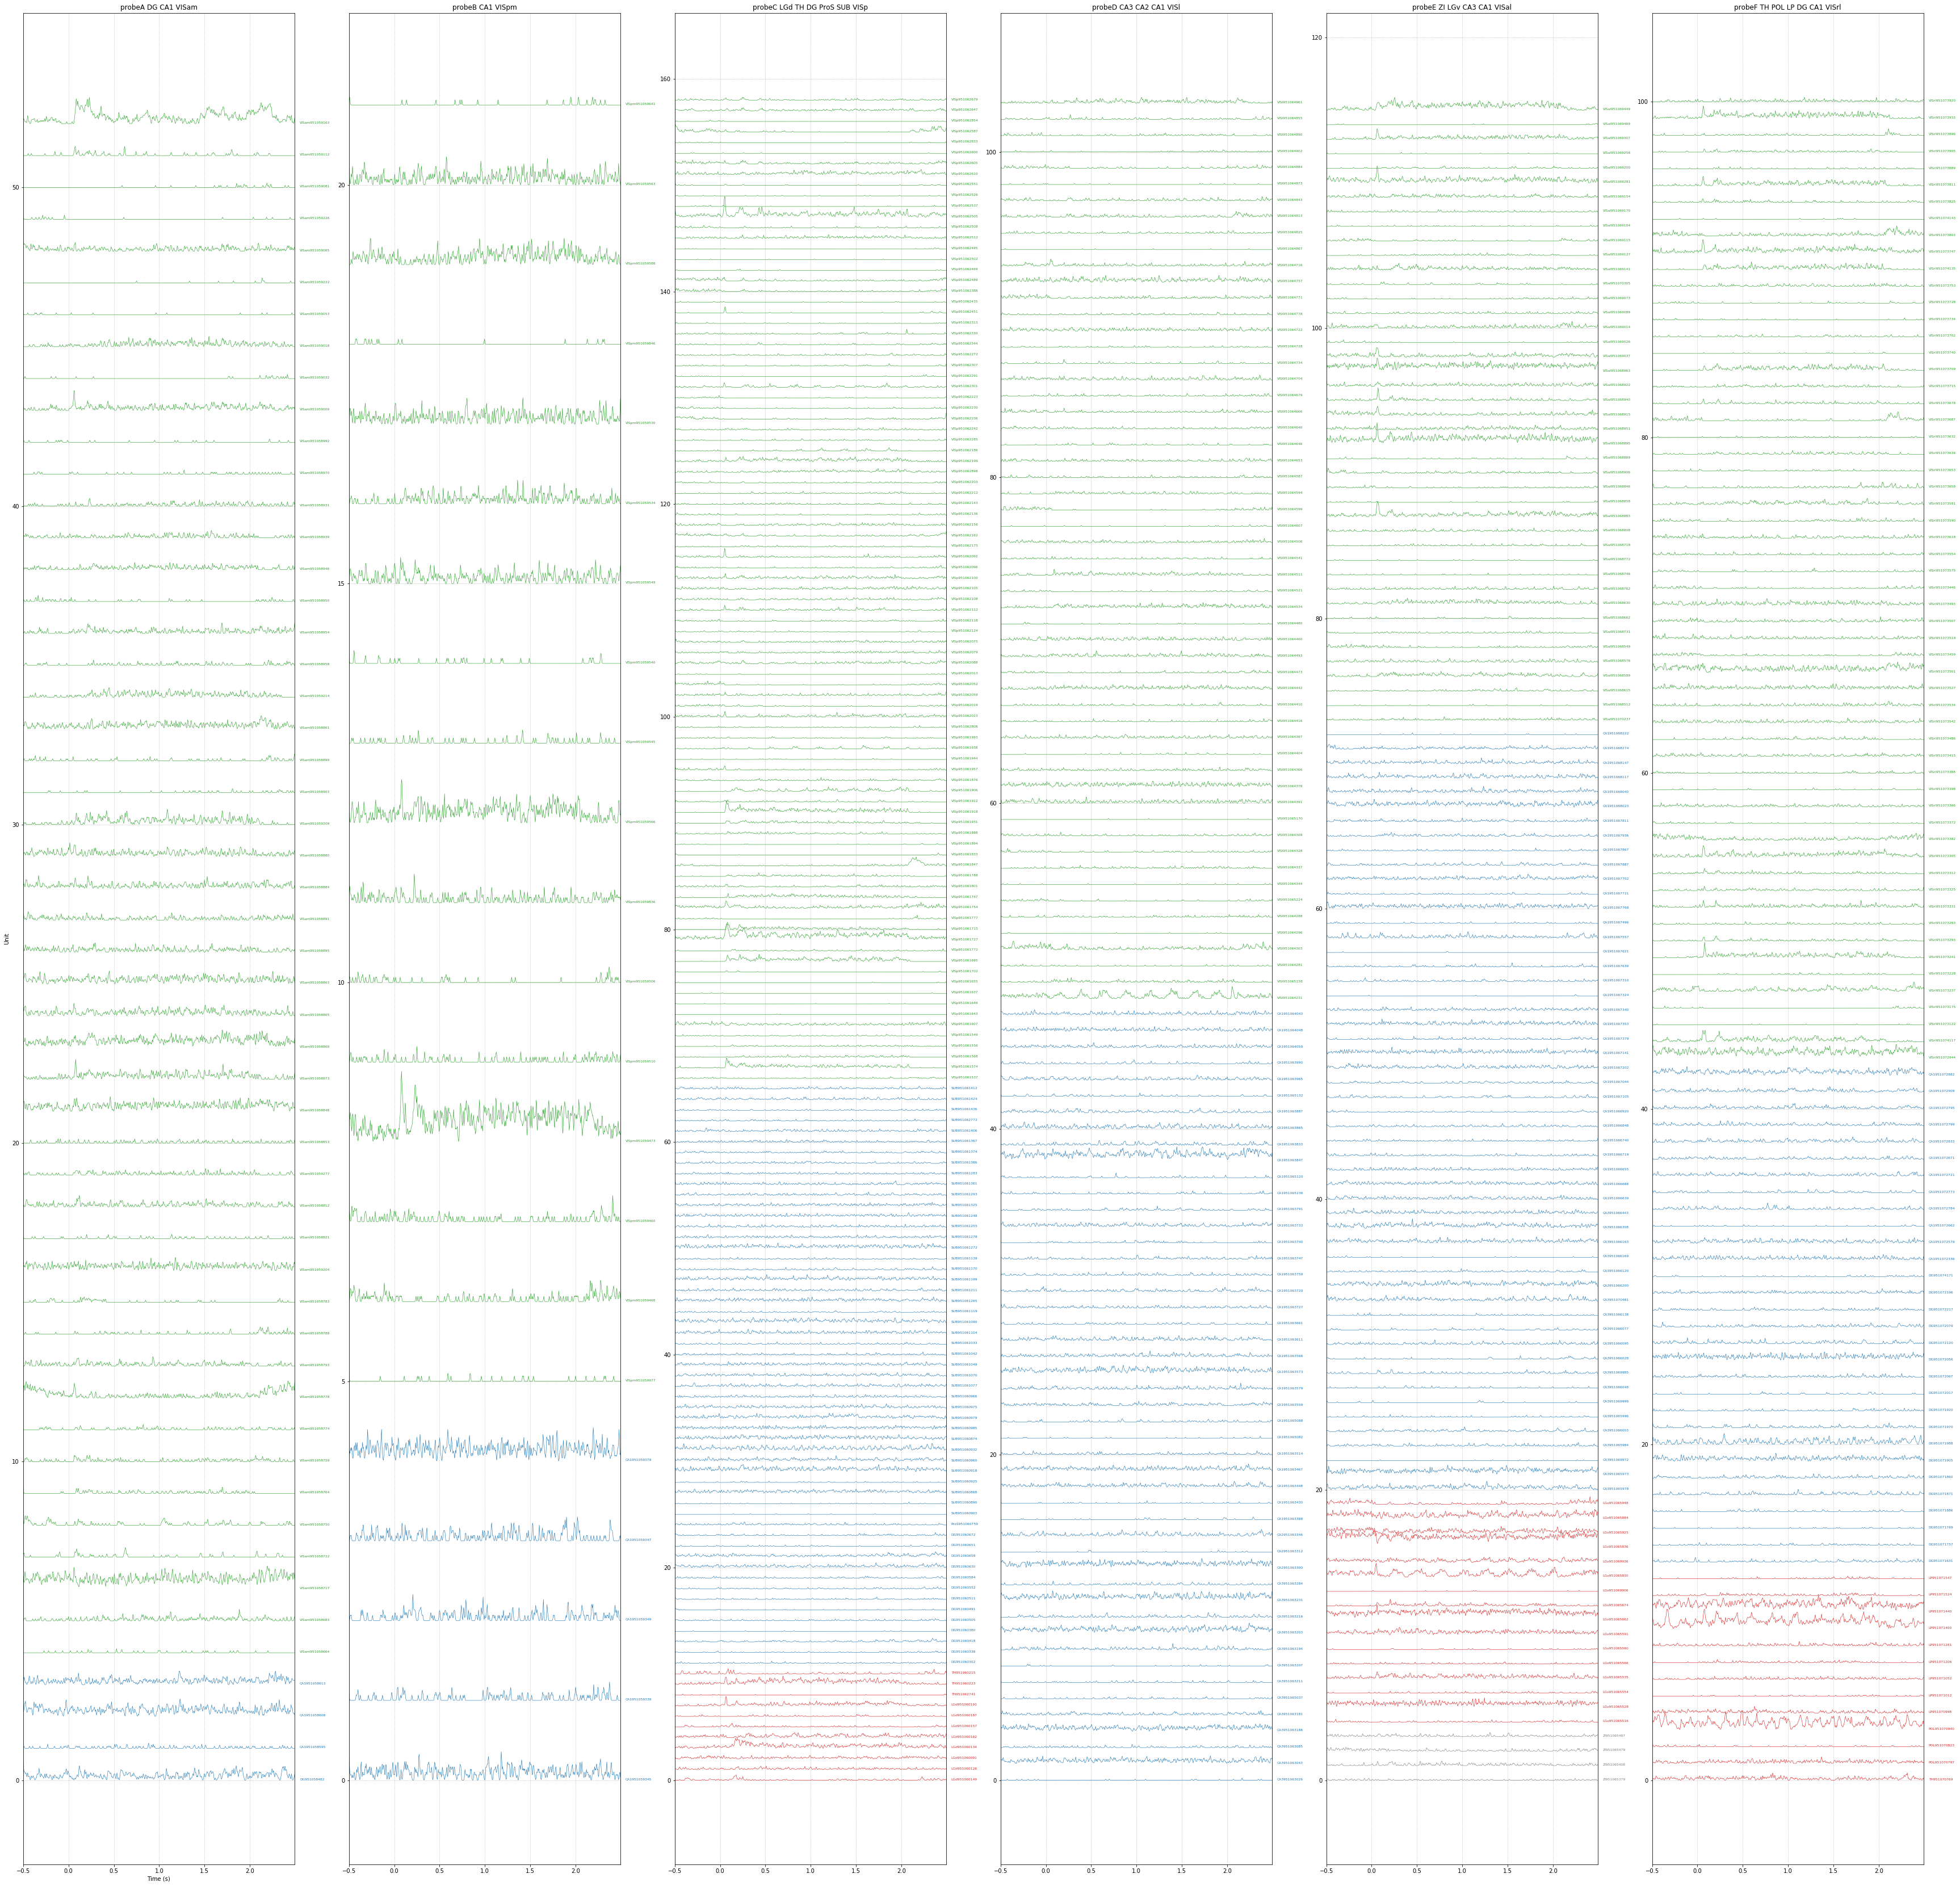

In [43]:
visualizer = data_visualizer.AllenInstituteDataVisualizer(session)
time_bin_edges = np.linspace(-0.5, 2.5, 3/0.005 + 1)

# trials_indices = [3798, 3927],
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_indices = stimulus_table[
    (stimulus_table['orientation']==45) & 
    (stimulus_table['temporal_frequency']==4)].index.values

visualizer.plot_all_psth_per_unit_per_probe(
    time_bin_edges=time_bin_edges,
    stimulus_presentation_ids=trials_indices,
    smooth_sigma=0.8)

... and plot the mean spike counts